In [ ]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
gprofiler           1.0.0
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.1
jupyterlab_server   2.1.2
kiwisol

In [4]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
import anndata2ri
rpy2.robjects.numpy2ri.activate()
anndata2ri.scipy2ri.activate()

In [5]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [6]:
# Set up data loading

#Data files
#These are the names of the different cell populations/sample groups that we will be using for this pipeline
sample_strings = ['1_', '2_']
# Last number in the sample id that is unique all other id numbers are the same. Wonder if this would work with more than 10 groups.
sample_id_strings = ['Ad-Id4GFP', 'Ad-Mouse-Sperm']
#Path to the files. Look how the file ends with the id beginning of the file and the only thing missing is the sample id value that is unique for each sample.
file_base = '/root/host_home/sc-rna-seq/data/GSE109033_'
#different file types tsv = files with feature and barcode sequences corresponding to row and column indices respectively. mtx
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
cc_genes_file = '/root/host_home/sc-rna-seq/data/Macosko_cell_cycle_genes.txt'

In [7]:
# First data set load & annotation
#Parse Filenames
#The .pop() function pops out an item in a sting that is indexed starting with 0 so .pop(0) means you are popping out the first item in the string
sample = sample_strings.pop(-1)
sample_id = sample_id_strings.pop(-1)
data_file = file_base+sample+sample_id+data_file_end
barcode_file = file_base+sample+sample_id+barcode_file_end
gene_file = file_base+sample+sample_id+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
#Transposing the adata object. Keep this in mind if you ever need to manually convert this from an AnnData to Single Cell Experiment object
adata = adata.transpose()
# Making the sparse matrix to simplify filtering out genes that aren't expressed 
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample_id]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
adata.var_names_make_unique()

... reading from cache file cache/root-host_home-sc-rna-seq-data-GSE109033_2_Ad-Mouse-Sperm_matrix.h5ad


In [7]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    sample_id = sample_id_strings[i]
    data_file = file_base+sample+sample_id+data_file_end
    barcode_file = file_base+sample+sample_id+barcode_file_end
    gene_file = file_base+sample+sample_id+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample_id]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id')
    if 'gene_id-1' in adata.var.columns:
        adata.var['gene_id'] = adata.var['gene_id-1']
        adata.var.drop(columns = ['gene_id-1', 'gene_id-0'], inplace=True)
    adata.obs.drop(columns=['sample_id'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

... reading from cache file cache/root-host_home-sc-rna-seq-data-GSE109033_1_Ad-Id4GFP_matrix.h5ad


In [8]:
adata.var

gene_id
gene_symbol                       
Xkr4            ENSMUSG00000051951
Gm1992          ENSMUSG00000089699
Gm37381         ENSMUSG00000102343
Rp1             ENSMUSG00000025900
Rp1-1           ENSMUSG00000109048
...                            ...
AC168977.1      ENSMUSG00000079808
PISD            ENSMUSG00000095041
DHRSX           ENSMUSG00000063897
Vmn2r122        ENSMUSG00000096730
CAAA01147332.1  ENSMUSG00000095742

[27998 rows x 1 columns]

In [9]:
# Annotate the data sets. This includes infomation about the samples each sample row name contains the unique barcode id for that sample and then the columns indicate the sample region and donor information about that sample which then can be realted to expression of given genes with the adata.var dataframe
print(adata.obs) # This tells us we have 13353 cells in this data set
print(adata.obs['sample'].value_counts())

                            sample
barcode                           
AAACCTGAGGTAGCTG-1  Ad-Mouse-Sperm
AAACCTGAGTCACGCC-1  Ad-Mouse-Sperm
AAACCTGGTCCGTGAC-1  Ad-Mouse-Sperm
AAACCTGGTGACCAAG-1  Ad-Mouse-Sperm
AAACCTGGTGCAGTAG-1  Ad-Mouse-Sperm
...                            ...
TTTGGTTGTAGCGCAA-3  Ad-Mouse-Sperm
TTTGGTTGTGAGTGAC-3  Ad-Mouse-Sperm
TTTGGTTGTGTAAGTA-3  Ad-Mouse-Sperm
TTTGTCACACAGGCCT-3  Ad-Mouse-Sperm
TTTGTCACACGAGGTA-3  Ad-Mouse-Sperm

[4651 rows x 1 columns]
Ad-Mouse-Sperm    4651
Name: sample, dtype: int64


In [10]:
# Checking the total size of the data set
adata.shape
#Here again we can see this data set contains 13353 cells or individual barcodes for samples and 27998 genes that could be possibly expressed.

(4651, 27998)

In [11]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1) #This uses the sparse matrix to sum all the cells in the matrix that have the value of indicating a count was recorded. This will give us an idea of how many count we collected which we can relate to if these counts mapped to actual genes. The (1) indicates they are again starring with the 2nd position in the list. (0) must be a dead space you need to skip over. 
adata.obs['log_counts'] = np.log(adata.obs['n_counts']) #we use numpy to store the log of the total count which will be easier to graph
adata.obs['n_genes'] = (adata.X > 0).sum(1) #Now you can see they are looking for counts that actually map to known genes which would be indicated in the sparse matrix as having a value greater than or equal to 1 as a opposed to a count which does not have a mapping and is recorded as a 0.

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names] #This will filter out from our gene index all of the genes that are mirochonrial in orgin.
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts'] #This will sum all of the counts in the sparse matrix that start with "mt-" and then divide it by the total count or reads to get the mitochonridal fraction of reads.

... storing 'sample' as categorical
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


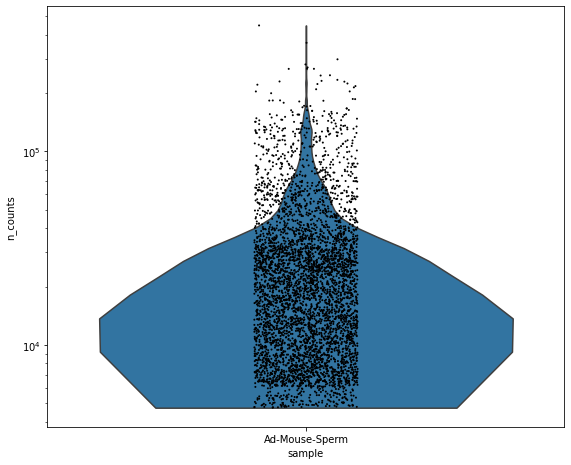

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


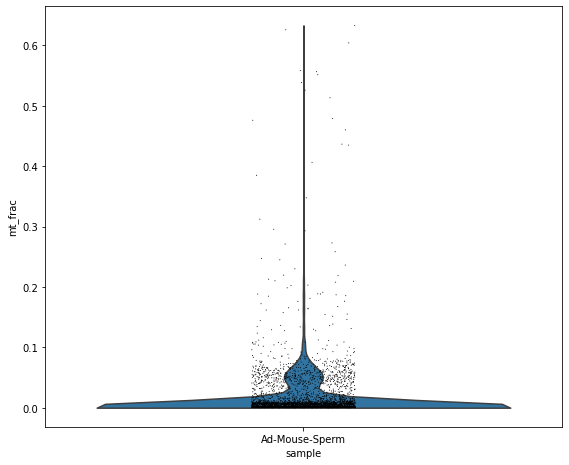

In [12]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=2, log=True, cut=0) #You can see the number of counts in each cell as it relates to its sample group. So far the sample with the lowest sample counts is jej_M2
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample') #Here you can see the ratio of mitochondrial counts in each cell. Even though the Jej_M2 is still the worst sample it does not rise above the cut off higher than 0.25. 

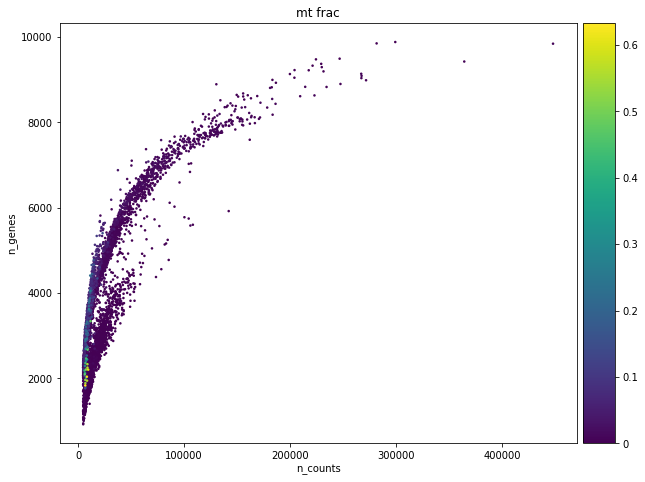

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


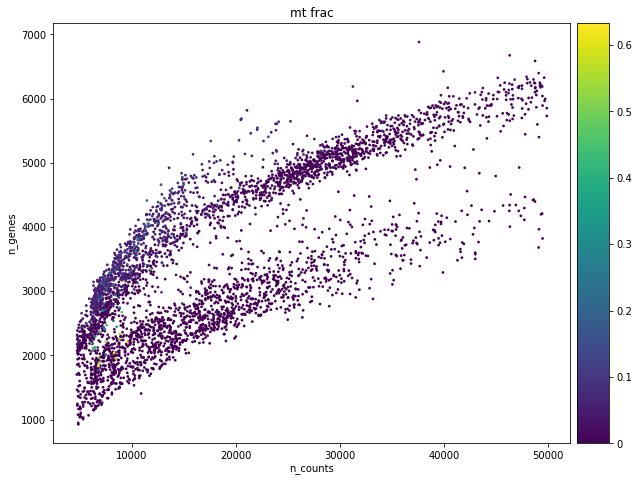

In [13]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac') #Here is a scatter plot displaying the previous information you can see that the majority of the counts are occuring around or below the 10000 n_counts mark so lets replot the grapgh with a cut off there to get a better view of that more densly packed data.
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<50000], 'n_counts', 'n_genes', color='mt_frac') # Now we can see this data more clearly. It looks okay no yellow dots and only a small portion of outliers that have low gene annotations with high read counts.

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


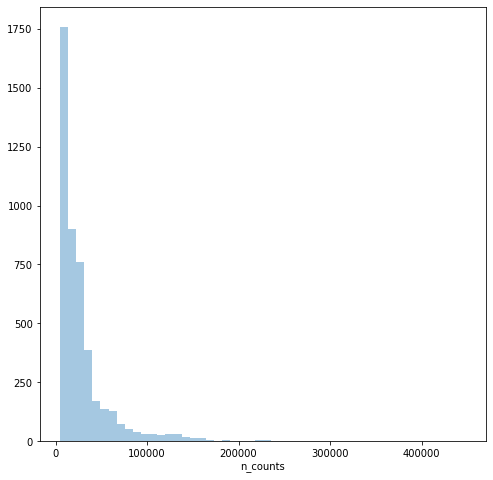

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


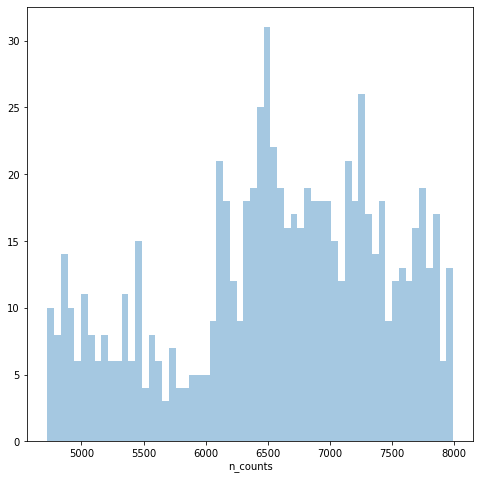

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


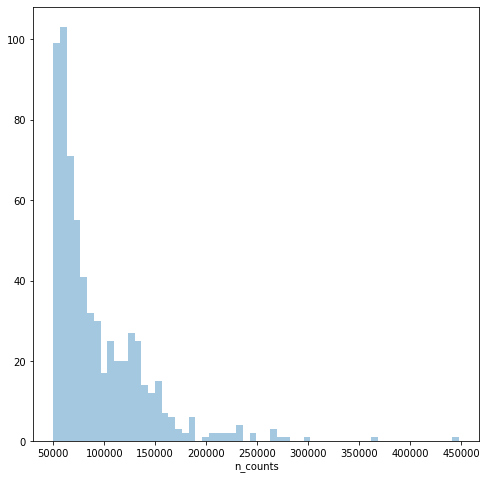

In [14]:
#Thresholding decision: counts # Here we will use histograms to threshold and cut away data that we do not want
p3 = sb.distplot(adata.obs['n_counts'], kde=False) #Show us all of the counts 
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<8000], kde=False, bins=60) #Okay, now show us only counts below 8000. This will show us the left half of the histogram so we can decide where to cut
plt.show()
# Looks like anything below 1500 count can probably be cut off and considered noise
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>50000], kde=False, bins=60) #Okay now lets look at the right side of the histogram. 
plt.show()
# This looks like anything above 40000 is probably a outlier and where we want to cut the high end of the data set.

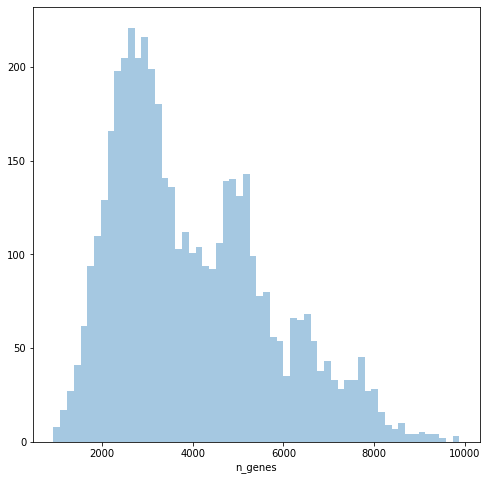

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


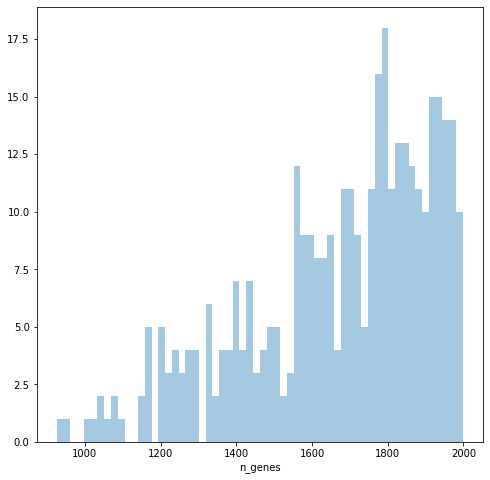

In [15]:
#Thresholding decision: genes # We will use a similar concept as in the previous section
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()
#There is a small dip in the left hand side that is where we want to cut
p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=60)
plt.show()
# Here it looks like right about the 750 gene mark is where we see that dip so we will cut a little bit higher than there.

In [16]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 3000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 300000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 750)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 4651


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Number of cells after min count filter: 4651
filtered out 2 cells that have more than 300000 counts
Number of cells after max count filter: 4649
Number of cells after MT filter: 4614


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 4614


In [17]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20) 
print('Number of genes after cell filter: {:d}'.format(adata.n_vars)) #Wow that pulled out nearly half of the genes which werent expressed in our samples. This is a much smaller and easier data set to work with.

Total number of genes: 27998
filtered out 10486 genes that are detected in less than 20 cells
Number of genes after cell filter: 17512


In [18]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy() #Here you make a copy using .copy() of the base anndata object to do normalization.
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6) #Use the scanpy package to normalize the cells by total counts over all genes in counts per million of reads or CPM
sc.pp.log1p(adata_pp) #sc.pp.log1p() computes the sparce matrix X = log(X+1) where log is a natrual log unless a different base is given. 
sc.pp.pca(adata_pp, n_comps=15) #computes a principle component analysis for the log normalized AnnData object.
sc.pp.neighbors(adata_pp) #computes a local neighborhood density that is indicating how related the data is to itself this is used for manifold approximation which is the underlying algorithm of UMAP (Uniform Manifold Approximation and Projection). Large values result in more golbal views on the manifold while smaller values result in more local data being preserved. The values should range from 2-100
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5) #This is a cool backstory. So this scanpy function is an algorythm that relates cell in single cell data together based on the similarities in expression of each cell. It was developed back in 2015 to look for gene signatures of acute myeloid leukemia (AML) as a big data driven push to find eraly markers for the disease. 

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [19]:
robjects.globalenv['data_mat'] = adata.X.T # This is our SingleCellExperiment object containing a sparce count matrix. The .T is just a short hand to tranpose the sparse matrix. Remember we are moving back into R and we need to transpose the anndata object so it looks like a single cell experiment object
robjects.globalenv['input_groups'] = adata_pp.obs['groups'] # Here are the groups that match up with the count matrix.
print(robjects.r.ls())

size_factors = robjects.r(f'sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters = input_groups, min.mean = 0.1))')
#We are jumping into R to use DESeq2 and compute the size factors varible using the "median ratio method" described by Equation 5 in Anders and Huber (2010). The function is supplied with the log normalized anndata count matrix which does not yet control for the library size.
#Take a look at that function we create the single cell object by building it from the transposed sparse matrix. Store the counts of data_mat (the transposed anndata sparse matrix) as a list and convert it into a single cell object. We then compute the sum factors of the single cell object and then the size factors.
#Pause! is the size_factors object in the R or python environment now??? remeber think about what rpy2 functions allow you to do in the 'python' environment...

[1] "data_mat"     "input_groups"



In [20]:
#Delete adata_pp object we now have the object that is controlled for the library size which is prefered to the adata_pp object. 
del adata_pp

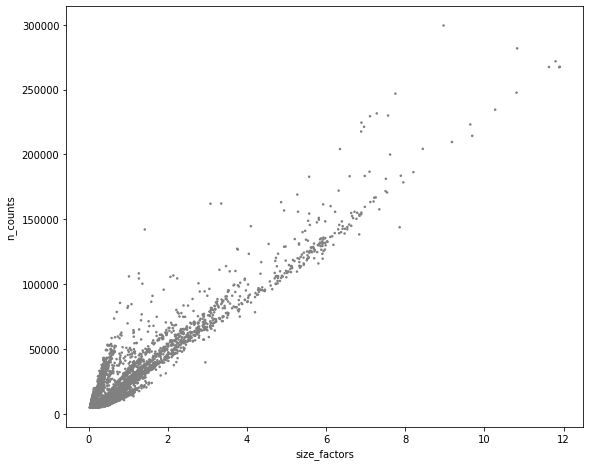

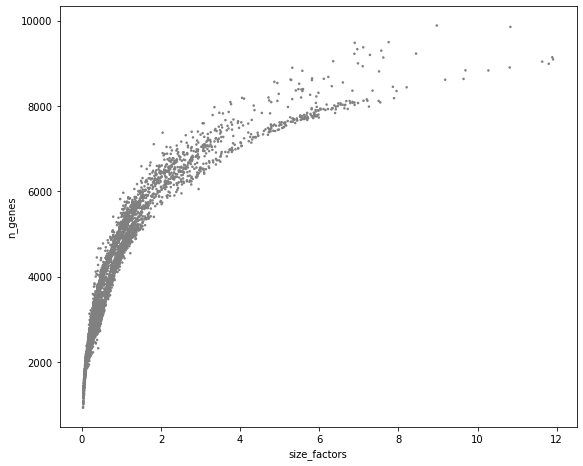

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


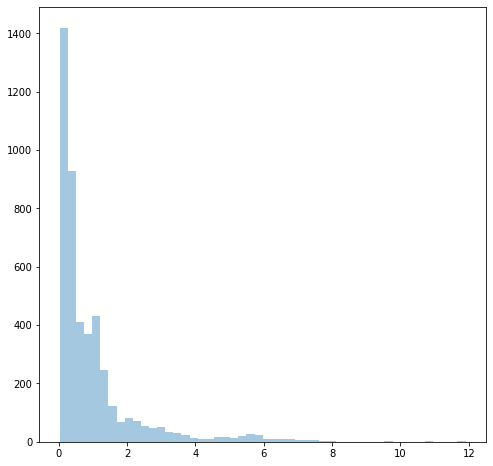

In [21]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors #Lets now add this on to the orginal adata.obs 

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')
# Here we plot the size factors just to check and make sure they are non-negative and increase in relation to both the number of genes and counts. 

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [22]:
#Keep the count data in a counts layer. We will need the raw counts object later down the pipeline so we save it here for future use in a counts layer of then sparce count matrix
adata.layers["counts"] = adata.X.copy()

In [23]:
#Normalize adata. /= divides the object on the left by the one on the right so in this case we are now applying the calculated size factors to the sparce count matrix.
adata.X /= adata.obs['size_factors'].values[:,None]
#We then normalize the data by applying a normalization of the adata object to visualize the counts as per million or CPM
sc.pp.log1p(adata)

In [24]:
# Store the full data set in 'raw' as log-normalised data for statistical testing. This is kinda a interesting layers of onions thing. we are going to keep using the adata object but we are storing a normalized "raw" chekcpoint inside the object itself.
adata.raw = adata

In [25]:
# ComBat batch correction. This removes any batch effects. A more updated version of this package can be found on bioconductor sva package.
sc.pp.combat(adata, key='sample')

Standardizing Data across genes.

Found 1 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/opt/python/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



In [26]:
# This expects log normalized data sets and scales highly variable genes using means and standard deviation of the dispersion of genes falling into bin for mean expression of genes to find outliers that exceed these calculated variances.
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


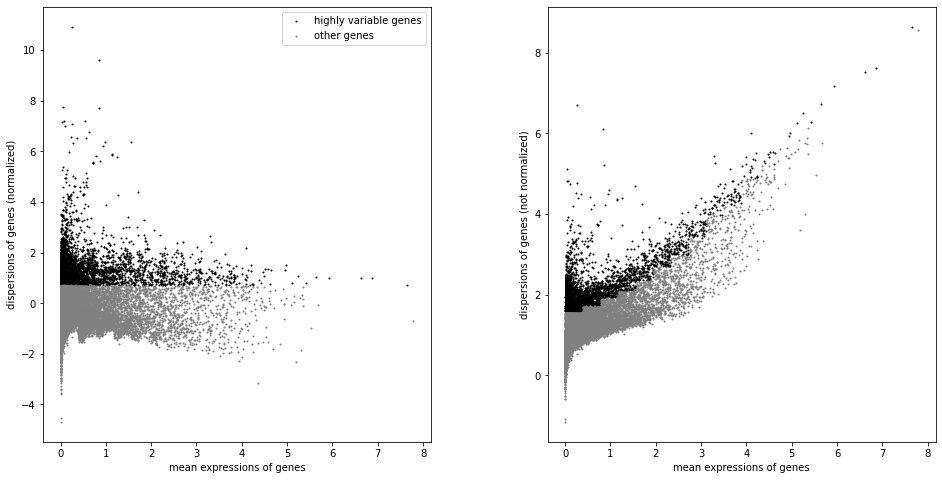

In [27]:
#lets visulize this and plot the mean experssion of genes before and after normalization. you can see the normalization of genes now has a normalized mean at a baseline of 0 on the left as opposed to the right. Yay now we can better compare expression of genes relative to each other.
sc.pl.highly_variable_genes(adata)

In [28]:
# Calculate the visualizations
#First we calculate the points for pca
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
#Then for UMAP
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
#This is a diffusion map that is a dimensionality reduction of feature extraction algorithm and computes a family of embeddings of a data set into Euclidean space (often low-dimensional) and whose coordinates can be computed from the eigenvectors and eigenvalues of a diffusion operator on the data.
sc.tl.diffmap(adata)
#This is a scatter plot using graph-drawing mathmatics. It's used by social network analysis to show how related the data set is to other points in the graphs. 
sc.tl.draw_graph(adata)

computing PCA
    on highly variable genes
    with n_comps=50


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:20)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:36)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.99911004 0.9971954  0.9965123  0.99392456
     0.9917756  0.9906072  0.98914844 0.9889094  0.98824203 0.9850207
     0.9829148  0.97930163 0.9775285 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:02)
drawing single-cell grap

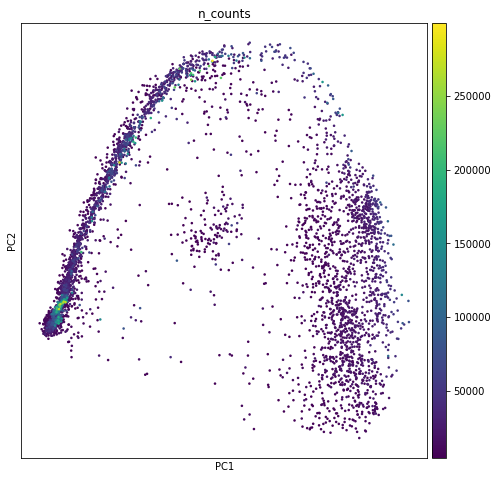

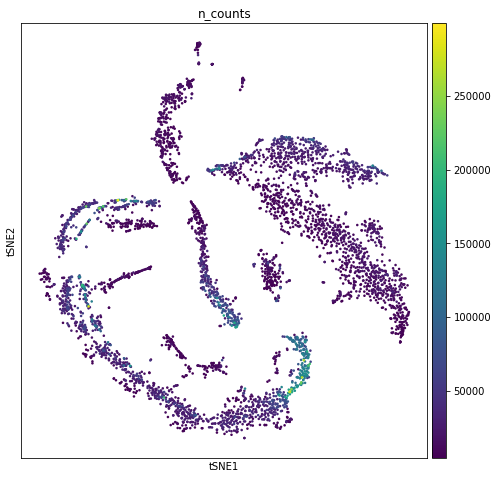

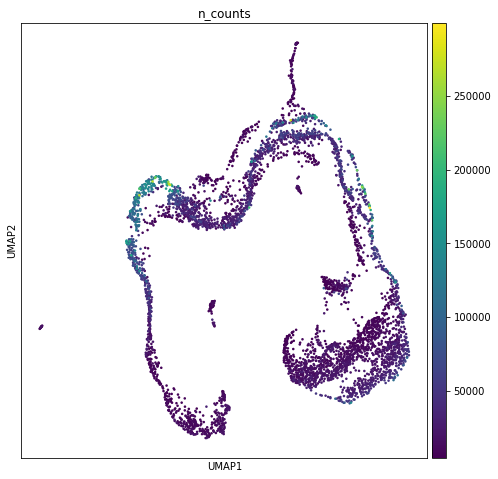

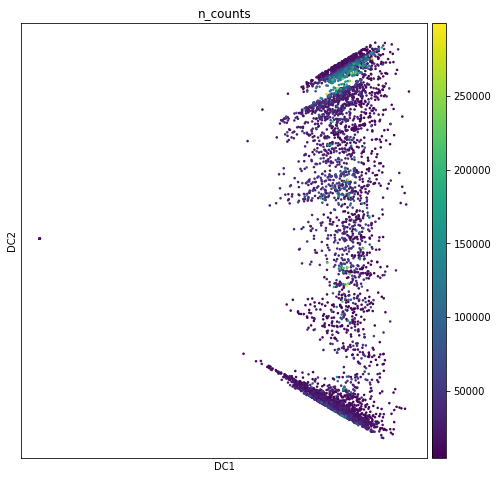

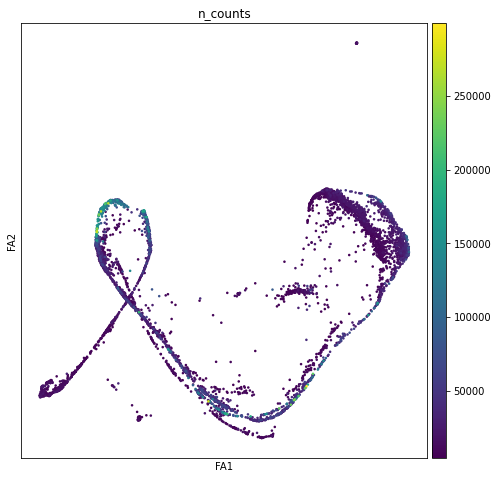

In [29]:
#Now lets plot these different graphs # you can see on all of these plots the cells that have higher counts are seperated from the rest of the data set and grouped together 
sc.pl.pca_scatter(adata, color='n_counts')
#This mainly only shows differnces in the count depth between cells as the grouping and is thus only marginally informative about the data set and what cell populations exsist inside of it.
sc.pl.tsne(adata, color='n_counts')
#Now we can see several distinct clusters with clear seperation but the connections between the clusters are more difficult to dicern.
sc.pl.umap(adata, color='n_counts')
#We can see clear clusters and the connections as well this is the best of the graphs so far.
sc.pl.diffmap(adata, color='n_counts')
#This shows connections really well as well as tragetories but the clusters are lost in the way the data is forced into "nodes" making it too densely packed. However these plots display the heterogeneity of the data set which is handy to visulize.
sc.pl.draw_graph(adata, color='n_counts')
#This is also a nice display of clusters and their connections with the center most likely being the stem cell population that gives rise to all the other groups. Still like the clustering on the UMAP more.

In [30]:
#Score cell cycle and visualize the effect: Here we are reading the Macosko_cell_cycle_genes.txt so we can relate expression of certain genes to cell cycle.
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
#Pulling out the genes that are related to S phase
s_genes = cc_genes['S'].dropna()
#Pulling out the genes that are related to G2.M phase
g2m_genes = cc_genes['G2.M'].dropna()

#This first makes all the letters lowecase with .lower() and then capitalize just the first letter .capitalize()
s_genes_mm = [gene.lower().capitalize() for gene in s_genes] 
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]
#This will now check if the s_genes_mm or g2m_genes_mm names are present in the adata.var_names data frame using the np.in1d which returns a boolean that is true when there is a match and false otherwise.
s_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]
#This function is designed to take in 3 imputs which are an anndata object and a list of genes associated with S and G2M phase which it then can use to score cells in the anndata object and assign the cell cycle phase G1, S, of G2M.
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)
# you can see in the output that the data is not only stored as the orginal score but then as the assigned phase both of which can be used with sc.pl to plot them on a graph

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    2132 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    2227 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


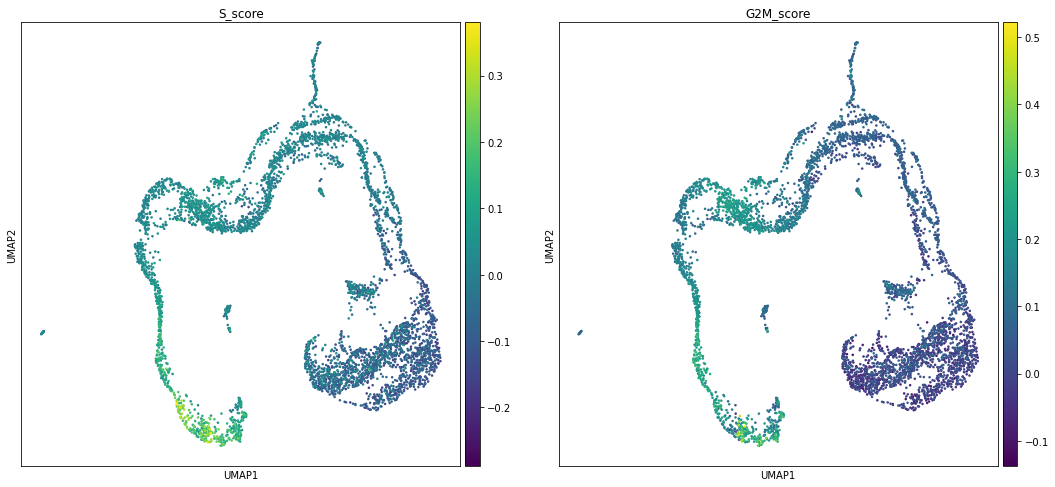

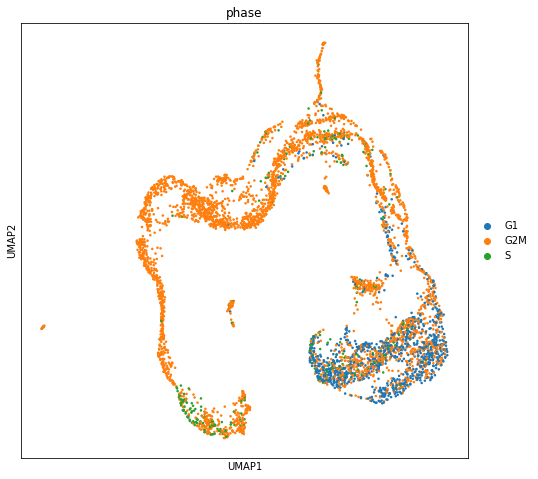

In [31]:
# Here we superimpose the cell cycle score calculated in the last section on top of the UMAP mapping.
sc.pl.umap(adata, color=['S_score', 'G2M_score'], use_raw=False)
sc.pl.umap(adata, color='phase', use_raw=False)
#You can change the umap out with any of the prviously calculated maps pca, tsne, diffmap, or draw_graph.

In [32]:
# Perform clustering - using highly variable genes. We use the louvain computation that we used in [18] again. 
sc.tl.louvain(adata, key_added='louvain_r1')
# Now lets decrease the resolution to do more of a rough pass. you can increase the resolution up to 1 to get more groups.
sc.tl.louvain(adata, resolution=0.1, key_added='louvain_r0.1', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain_r0.1', the cluster labels (adata.obs, categorical) (0:00:00)


In [33]:
#Lets see how many groups we got. Looks like 9.
adata.obs['louvain_r0.1'].value_counts()

0    1699
1     995
2     617
3     531
4     392
5     364
6      16
Name: louvain_r0.1, dtype: int64

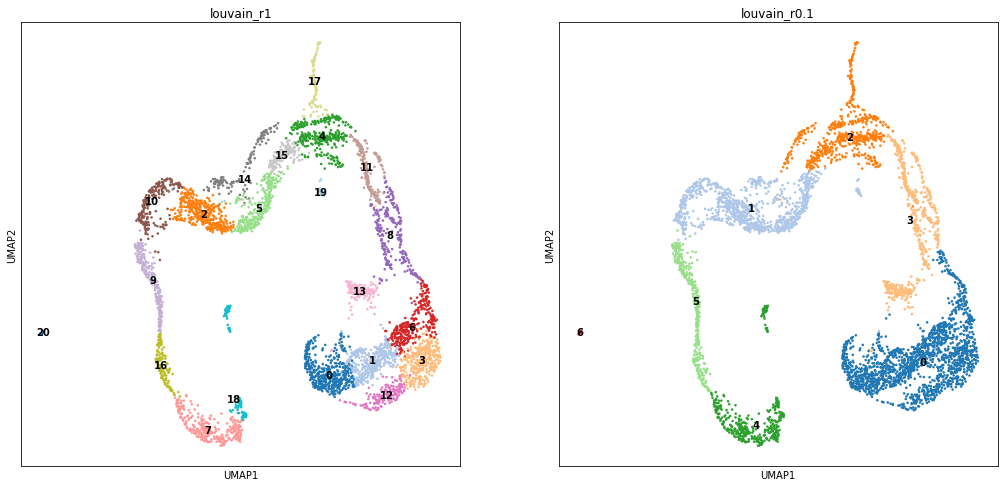

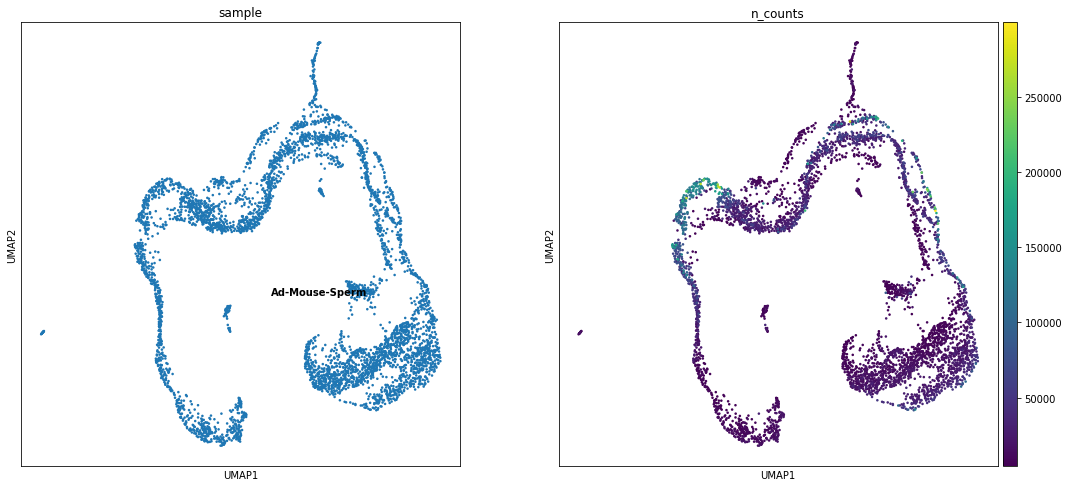

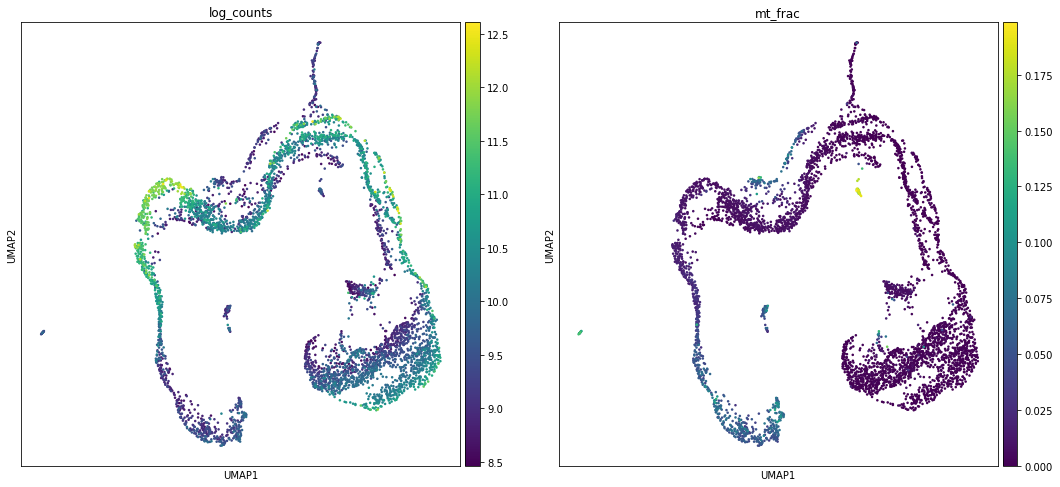

In [34]:
#Visualize the clustering and how this is reflected by different technical covariates
#There are 14 groups at the highest resolution
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.1'], legend_loc='on data', palette=sc.pl.palettes.vega_20)
#Here we can see the region the samples came from Duo, Il, Jej. As well as n_counts.
sc.pl.umap(adata, color=['sample', 'n_counts'], legend_loc='on data')
#Finally lets look at the log counts and mitochondrial fraction. 
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

In [35]:
#Calculate marker genes # This functions expects log normalized data and will rank genes for characterizing groups
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.1', key_added='rank_genes_r0.1')

ranking genes
    finished: added to `.uns['rank_genes_r0.1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


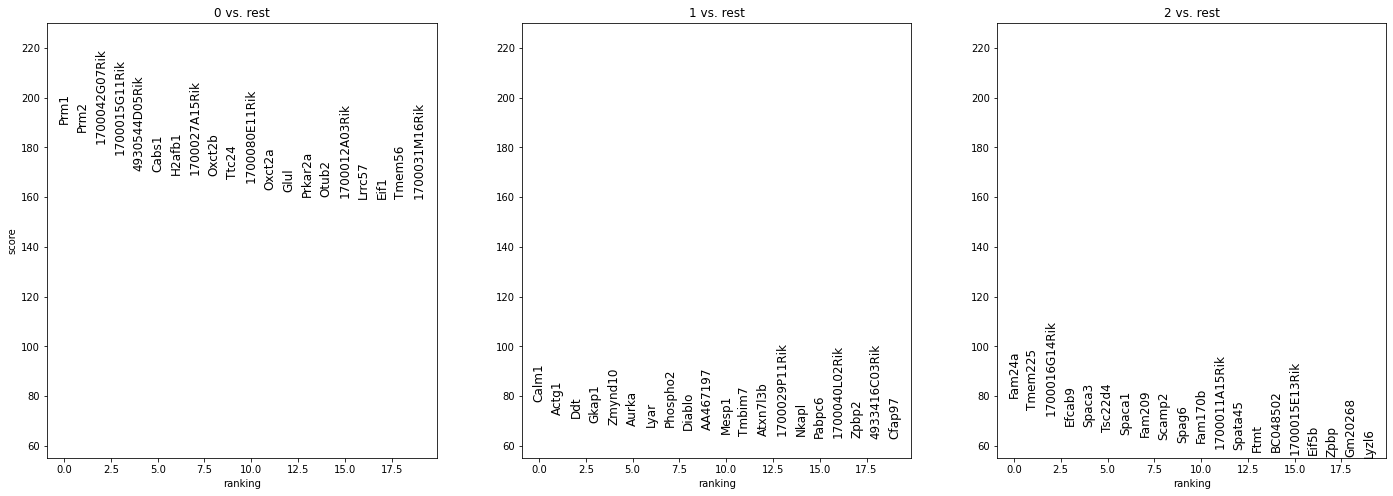

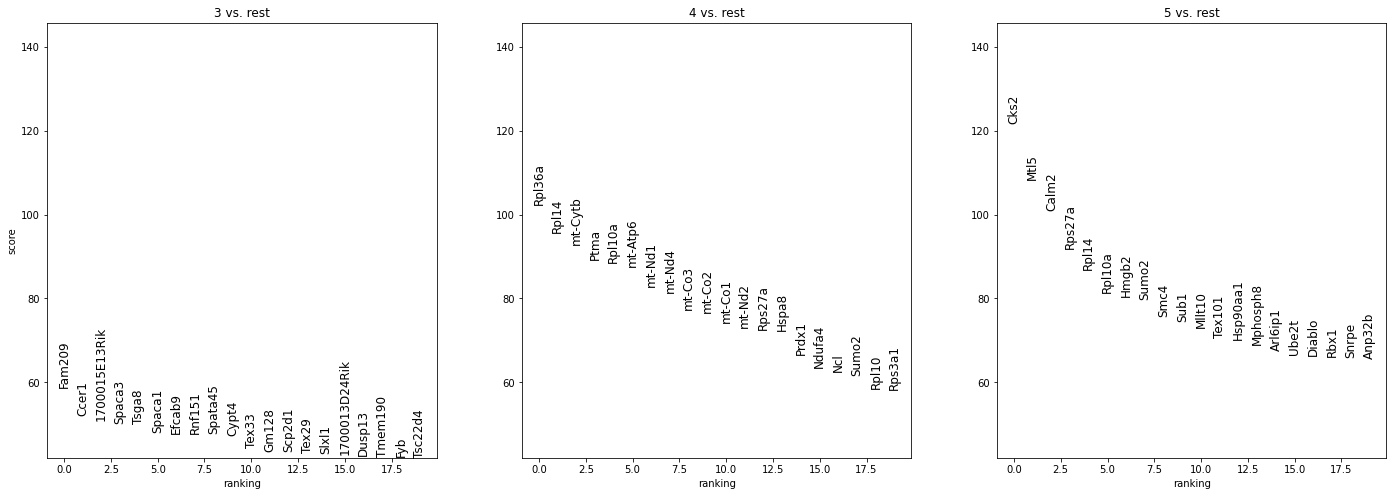

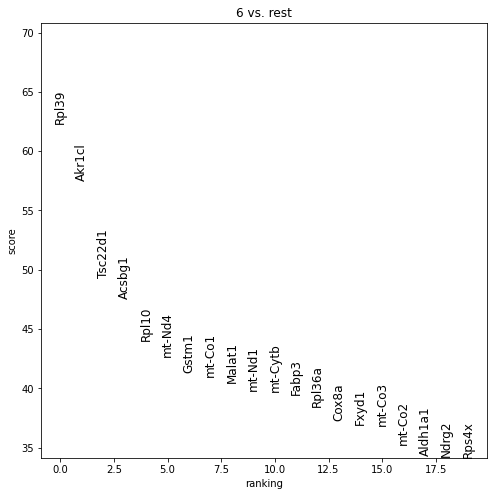

In [36]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.1', groups=['0','1','2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.1', groups=['3','4','5'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.1', groups=['6'], fontsize=12)
#First inspection of the marker gene plots shows that cluster 3 is characterized by high expression of mitochonrial genes as shown by the plots above.
#To identify other clusters we look at the overlap woth known marker genes. Use marker gene sets obtained from public databases like Linnarson's mouse brain atlas or other Human cell atlas data sets to best fit your data.

In [37]:
#Known marker genes:
marker_genes = dict()
marker_genes['SSC'] = ['Bcl6b', 'Cyp26a1', 'Dusp6', 'Etv5', 'Foxo1', 'Gfra1', 'Id4', 'Nanos2', 'Nanos3', 'Tspan8', 'Lin28a', 'Neurog3', 'Pax7', 'Piwil4', 'Sall4', 'Tcl', 'Zbtb16']
marker_genes['Progenitor Spg'] = ['Rhox10', 'Utf1']
marker_genes['Early Diff Spg'] = ['Bmi1', 'Dmc1', 'Dmrt1', 'Kit', 'Ndrg4', 'Rhoxl3', 'Sohlh1', 'Sohlh2', 'Stra8', 'Sycp3', 'Uchl1']
marker_genes['Late Diff Spg'] = ['Dnmt1', 'Taf4b']
marker_genes['Preleptotene'] = ['Cetn2', 'Cited1', 'Kit', 'Pgk1', 'Rad51', 'Rhox13', 'Scml2', 'Stra8', 'Tex19', 'Zfy1']
marker_genes['Lep-Zyg Early Pach'] = ['Atr', 'Dicer1', 'Dmc1', 'Gal3st1', 'Mlh1', 'Rad51ap2', 'Rpa2', 'Scml2', 'Sycp1', 'Top2b', 'Zfy1']
marker_genes['Pachytene_Mid'] = ['Ccnb1', 'Ccnb1ip1', 'Gml', 'Gml2', 'Meiob', 'Msh3', 'Peg10', 'Piwil2', 'Sycp3']
marker_genes['Pachytene_Late'] = ['Cetn1', 'Cetn4', 'Dyx1c1', 'Elfn2', 'Mtbl1', 'Ldha', 'Ldhc', 'Piwil1', 'Pou5f2']
marker_genes['Dipl/Secondary'] = ['Adam3', 'Cetn3', 'Fa2h', 'Kctd9', 'Pgk2']
marker_genes['Early Std'] = ['Icqa', 'Ldha', 'Prss42', 'Rbm5', 'Speer4e', 'Ssxb1', 'Ssxb2', 'Sycp3']
marker_genes['Mid Std'] = ['Cetn1', 'Ldhc', 'Ybx1']
marker_genes['Late Std'] = ['Akap4', 'Aldoa', 'Car2', 'Cby3', 'Cyp2al2', 'Gapdhs', 'Klkb3', 'Pgk2', 'Prm1', 'Prm2', 'Prm3', 'Tnp1', 'Tnp2', 'Tmod4']
marker_genes['Sertoli'] = ['Wt1', 'Sox9', 'Ar']

In [48]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.1')
cell_annotation

0     1     2     3     4     5     6
SSC                 11.0  11.0  11.0  11.0  11.0  11.0  11.0
Progenitor Spg       2.0   2.0   2.0   2.0   2.0   2.0   2.0
Early Diff Spg      10.0  10.0  10.0  10.0  10.0  10.0  10.0
Late Diff Spg        2.0   2.0   2.0   2.0   2.0   2.0   2.0
Preleptotene         9.0   9.0   9.0   9.0   9.0   9.0   9.0
Lep-Zyg Early Pach  11.0  11.0  11.0  11.0  11.0  11.0  11.0
Pachytene_Mid        9.0   9.0   9.0   9.0   9.0   9.0   9.0
Pachytene_Late       8.0   8.0   8.0   8.0   8.0   8.0   8.0
Dipl/Secondary       5.0   5.0   5.0   5.0   5.0   5.0   5.0
Early Std            7.0   7.0   7.0   7.0   7.0   7.0   7.0
Mid Std              3.0   3.0   3.0   3.0   3.0   3.0   3.0
Late Std            12.0  12.0  12.0  12.0  12.0  12.0  12.0
Sertoli              3.0   3.0   3.0   3.0   3.0   3.0   3.0

<AxesSubplot:>

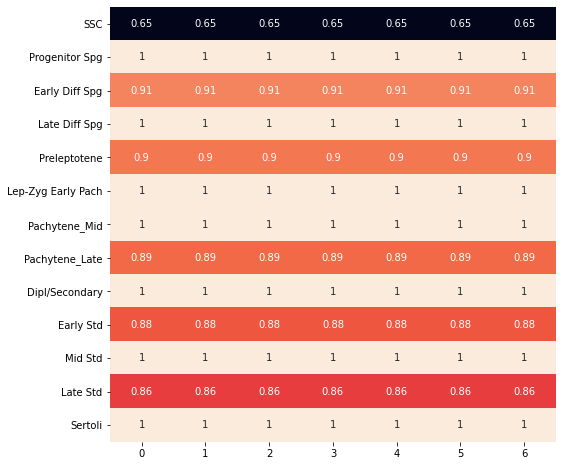

In [52]:
#This helps visulize the marker gene overlap as a fraction of the total marker and then plot it as a heatmap to help simplify cell identity annotation
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)
# There looks like there is a considerable overlap with the cells in group 6 having markers for both paneth and globlet cells. Let's dig more inot this in the next section to correctly identify which cluster is which.

In [53]:
#Define a nice color map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

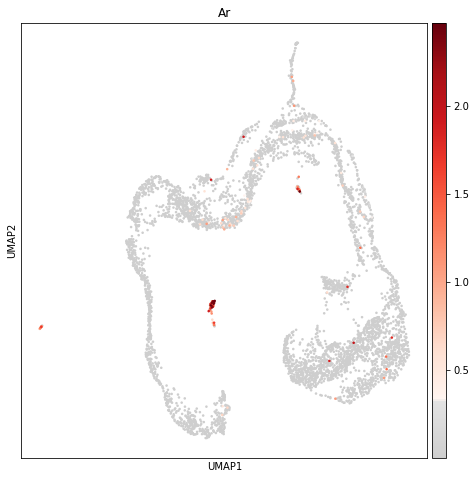

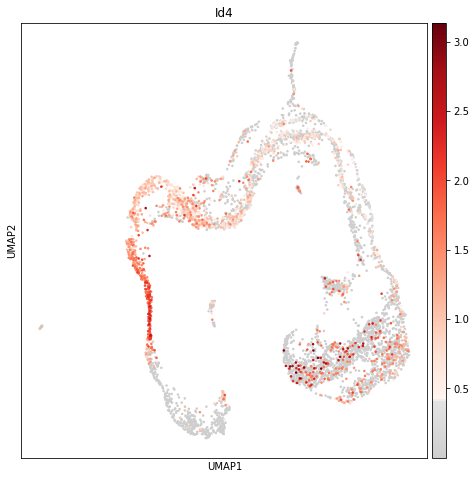

In [59]:
#We can check that our color for gene expression was set up correctly by checking for a few markers in this section and display them on the UMAPs we have already computed. 
sc.pl.umap(adata, color='Ar', use_raw=False, color_map=mymap)
sc.pl.umap(adata, color='Id4', use_raw=False, color_map=mymap)

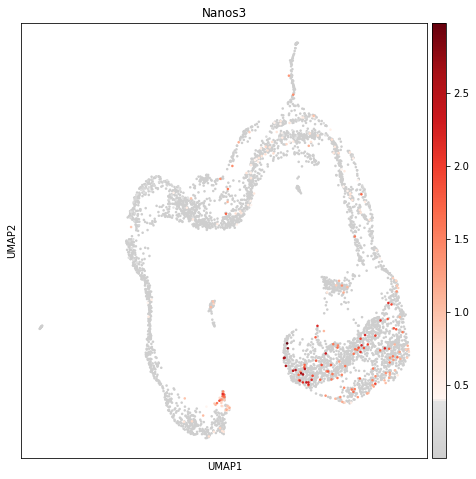

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


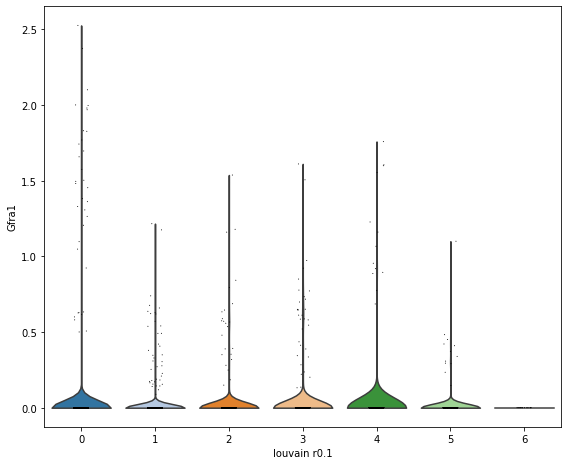

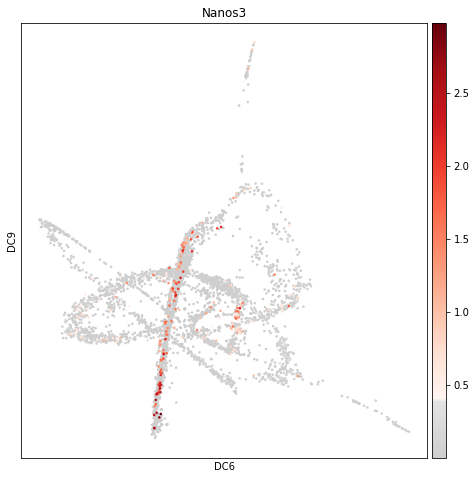

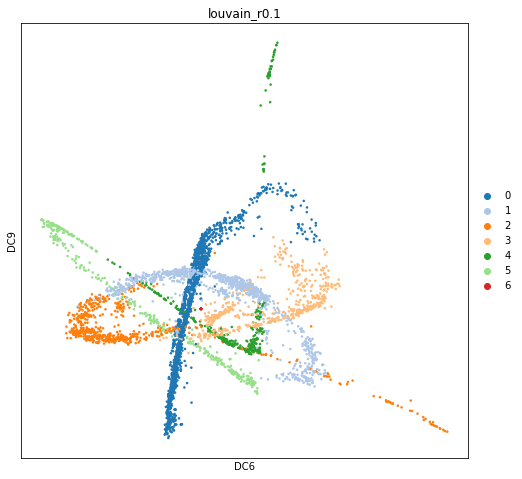

In [60]:
#Early SSC marker - Nanos3
#If you wanted to use one marker to check of an individual cell marker this is how you would do that.
#You can see however, that the SSC marker Nanos3 indicates that the population that contains the most expression is group 0 and group 4 this is an exsample of why we must use multiple markers to identify cell types instead of just one.
sc.pl.umap(adata, color='Nanos3', use_raw=False, color_map=mymap)

sc.pl.violin(adata, groupby='louvain_r0.1', keys='Gfra1', use_raw=False)

sc.pl.diffmap(adata, components=['6,9'], color='Nanos3', use_raw=False, color_map=mymap)
sc.pl.diffmap(adata, components=['6,9'], color='louvain_r0.1')

In [61]:
# Check expression of cell markers # This is what you would do if you needed to used more than one marker to identify a cell group.
#Collate all cell markers and get the gene IDs in the data set
ids_SSC = np.in1d(adata.var_names, marker_genes['SSC'])
ids_ProSpg = np.in1d(adata.var_names, marker_genes['Progenitor Spg'])
ids_EDS = np.in1d(adata.var_names, marker_genes['Early Diff Spg'])
ids_LDS = np.in1d(adata.var_names, marker_genes['Late Diff Spg'])
ids_Prelep = np.in1d(adata.var_names, marker_genes['Preleptotene'])
ids_LZ = np.in1d(adata.var_names, marker_genes['Lep-Zyg Early Pach'])
ids_PM = np.in1d(adata.var_names, marker_genes['Pachytene_Mid'])
ids_PL = np.in1d(adata.var_names, marker_genes['Pachytene_Late'])
ids_DS = np.in1d(adata.var_names, marker_genes['Dipl/Secondary'])
ids_ES = np.in1d(adata.var_names, marker_genes['Early Std'])
ids_MS = np.in1d(adata.var_names, marker_genes['Mid Std'])
ids_LS = np.in1d(adata.var_names, marker_genes['Late Std'])
ids_S = np.in1d(adata.var_names, marker_genes['Sertoli'])

#Calculate the mean expression of each cell type markers.
adata.obs['SSC'] = adata.X[:,ids_SSC].mean(1)
adata.obs['Progenitor Spg'] = adata.X[:,ids_ProSpg].mean(1)
adata.obs['Early Diff Spg'] = adata.X[:,ids_EDS].mean(1)
adata.obs['Late Diff Spg'] = adata.X[:,ids_LDS].mean(1)
adata.obs['Preleptotene'] = adata.X[:,ids_Prelep].mean(1)
adata.obs['Lep-Zyg Early Pach'] = adata.X[:,ids_LZ].mean(1)
adata.obs['Pachytene_Mid'] = adata.X[:,ids_PM].mean(1)
adata.obs['Pachytene_Late'] = adata.X[:,ids_PL].mean(1)
adata.obs['Dipl/Secondary'] = adata.X[:,ids_DS].mean(1)
adata.obs['Early Std'] = adata.X[:,ids_ES].mean(1)
adata.obs['Mid Std'] = adata.X[:,ids_MS].mean(1)
adata.obs['Late Std'] = adata.X[:,ids_LS].mean(1)
adata.obs['Sertoli'] = adata.X[:,ids_S].mean(1)

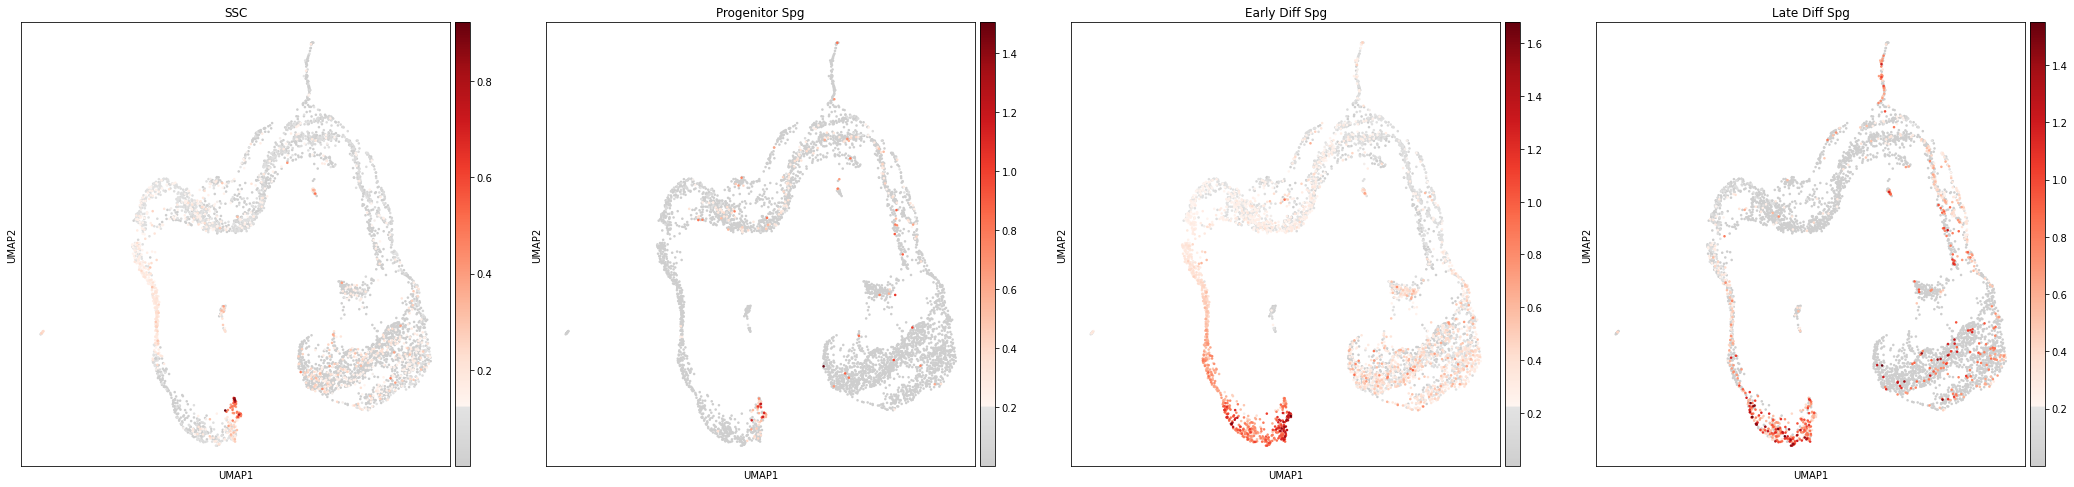

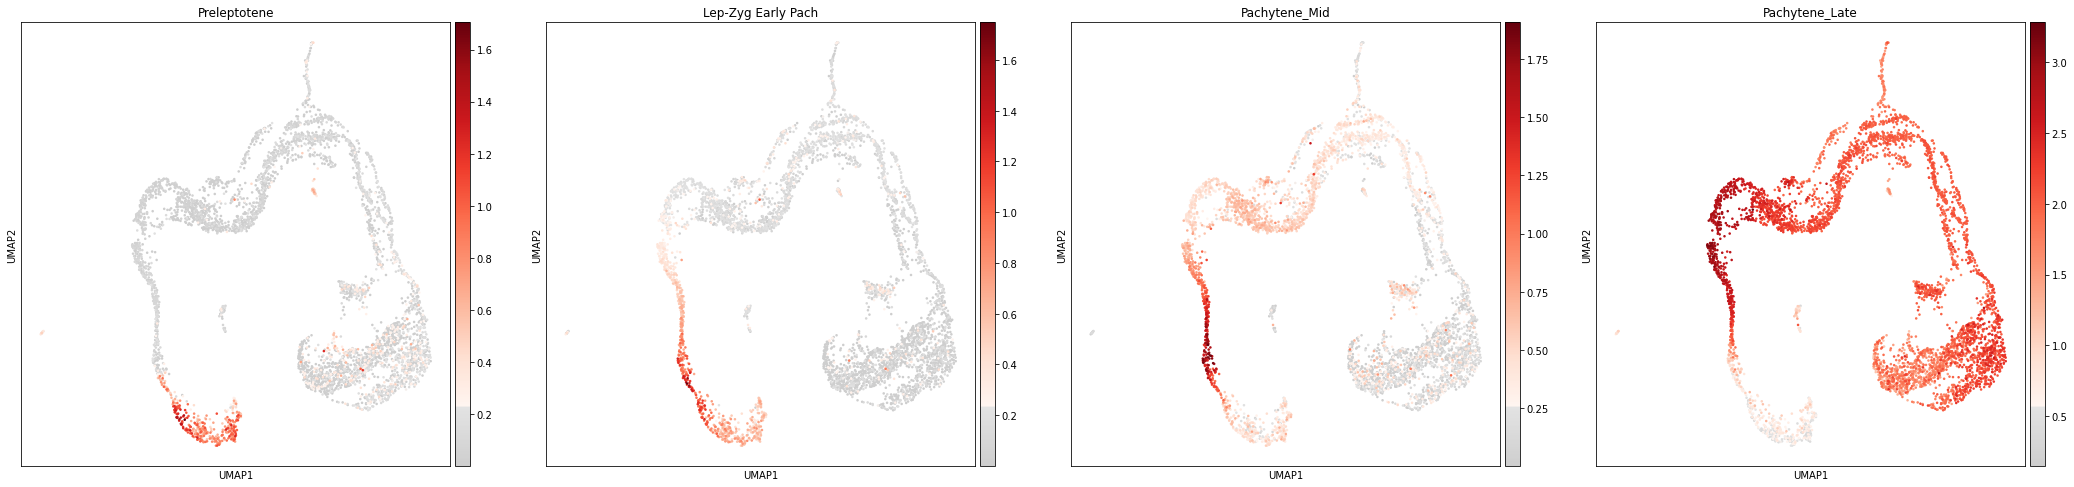

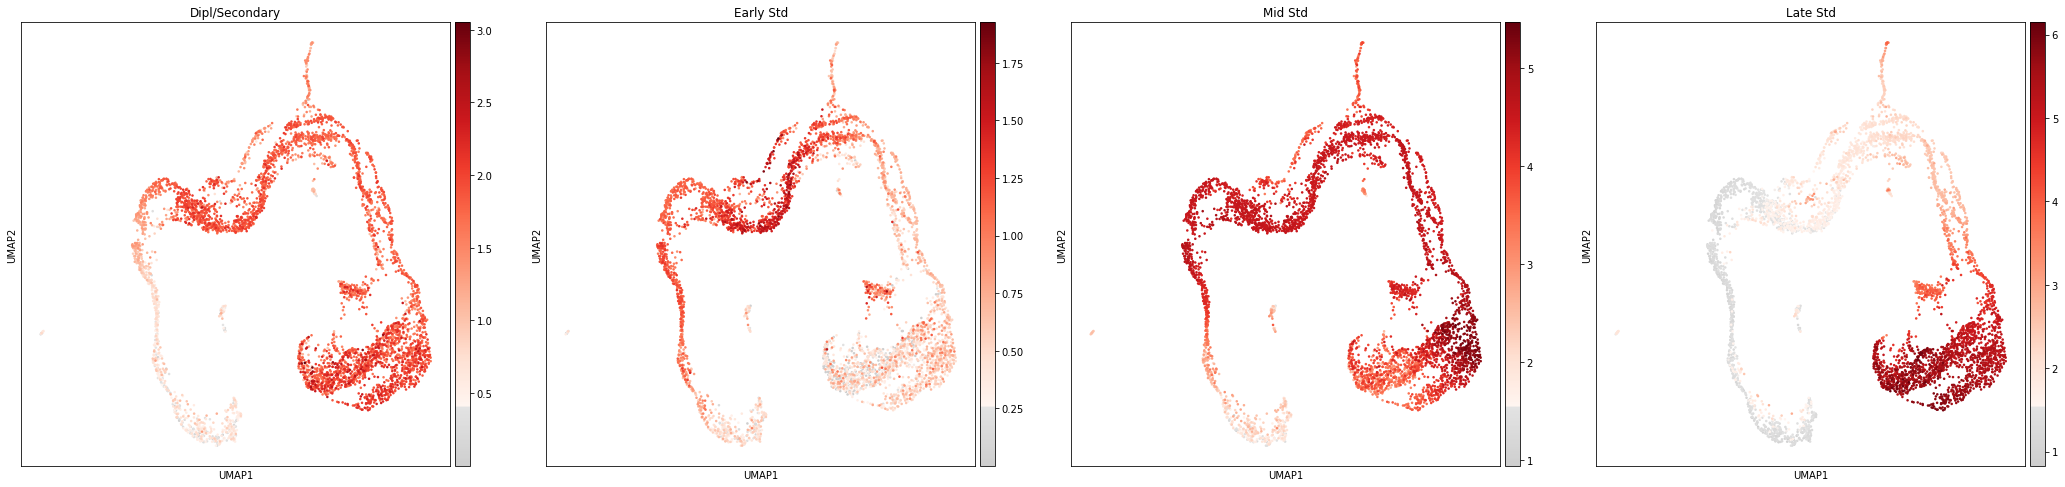

In [62]:
#Plot cell marker expression on UMAP
sc.pl.umap(adata, color=['SSC', 'Progenitor Spg', 'Early Diff Spg', 'Late Diff Spg'], color_map=mymap)
sc.pl.umap(adata, color=['Preleptotene','Lep-Zyg Early Pach','Pachytene_Mid', 'Pachytene_Late'], color_map=mymap)
sc.pl.umap(adata, color=['Dipl/Secondary', 'Early Std', 'Mid Std', 'Late Std'], color_map=mymap)
#You can see that there is an even flow of the expression of the different classifications of cell types from the left moving to the right of the cells displayed on the UMAP display.
#We need to start matching the groups to the individual cell type based on expression of these marker genes.
#Based on this you can see that the cell types from SSC-Preleptoene are represented in group 4, with Lep-Pachytene_Late being represneted largely in group 5, all of the other cell types falling into their own group based on the louvain clustering at the low resolution. We will confirm this in the next section using violin plots.  

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


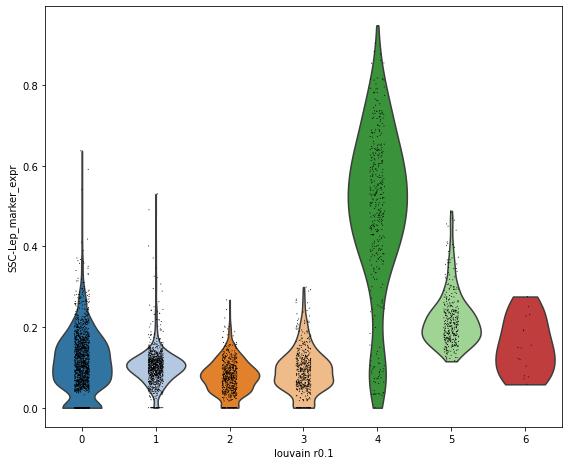

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


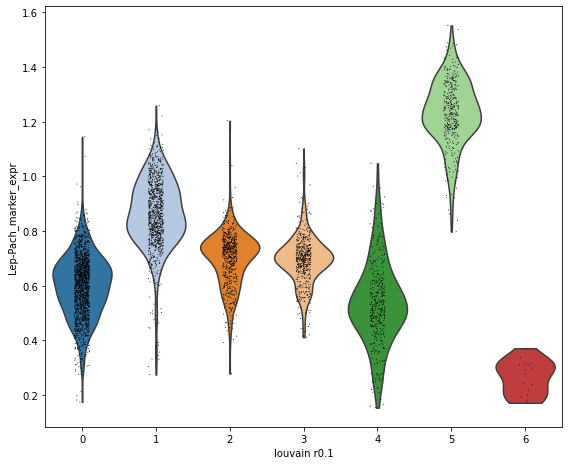

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


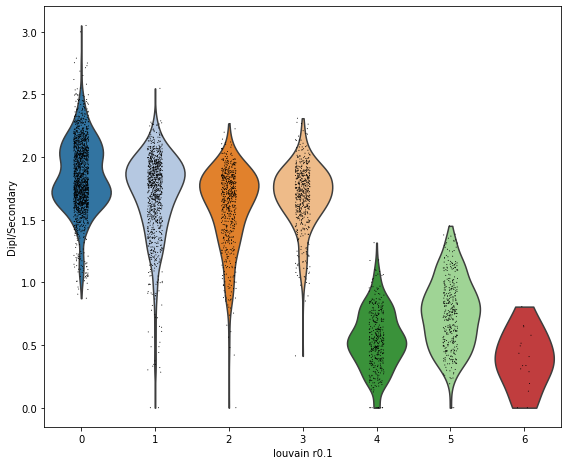

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


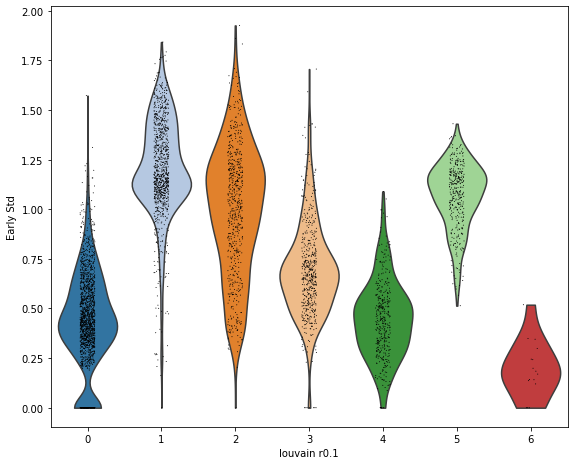

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


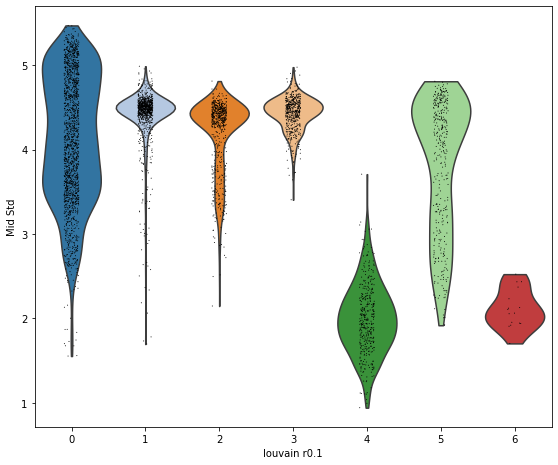

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


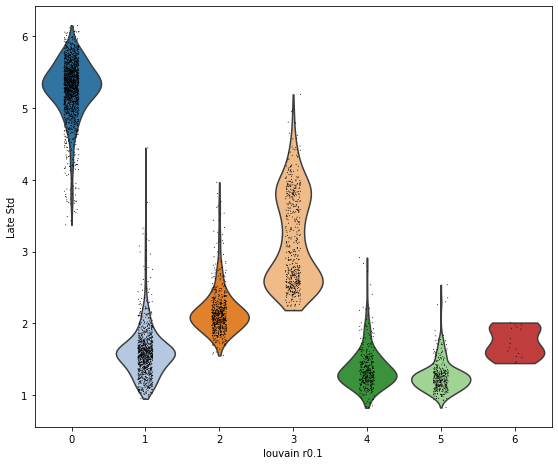

In [63]:
#Check individual cell-type specific markers using violin plots
SSC_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['SSC'])]
Pro_Spg_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['Progenitor Spg'])]
Early_Diff_Spg_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['Early Diff Spg'])]
Late_Diff_Spg_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['Late Diff Spg'])]
Preleptotene_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['Preleptotene'])]
SSC_Lep_genes = np.concatenate((SSC_genes, Pro_Spg_genes, Early_Diff_Spg_genes, Late_Diff_Spg_genes, Preleptotene_genes), axis=0, out=None)
adata.obs['SSC-Lep_marker_expr'] = adata[:,SSC_Lep_genes].X.mean(1)

sc.pl.violin(adata, 'SSC-Lep_marker_expr', groupby='louvain_r0.1') #SSC-Lep marker expression occurs in group 4

Lep_Zyg_Early_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['Lep-Zyg Early Pach'])]
Pach_Mid_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['Pachytene_Mid'])]
Pach_Late_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['Pachytene_Late'])]

Lep_Pach_genes = np.concatenate((Lep_Zyg_Early_genes, Pach_Mid_genes, Pach_Late_genes), axis=0, out=None)
adata.obs['Lep-Pach_marker_expr'] = adata[:,Lep_Pach_genes].X.mean(1)

sc.pl.violin(adata, 'Lep-Pach_marker_expr', groupby='louvain_r0.1') #Lep-Pach marker expression occurs in group 5

sc.pl.violin(adata, 'Dipl/Secondary', groupby='louvain_r0.1') #This one was close but looks like there aew slightly more expression Dipl/Secondary in group 1
sc.pl.violin(adata, 'Early Std', groupby='louvain_r0.1') #The Early Std are in group 2
sc.pl.violin(adata, 'Mid Std', groupby='louvain_r0.1') #This is a little more tough to see where the #Mid Std should go it looks like this could either be group 6 or group 3
sc.pl.violin(adata, 'Late Std', groupby='louvain_r0.1') #The Late Std are clearly group 6

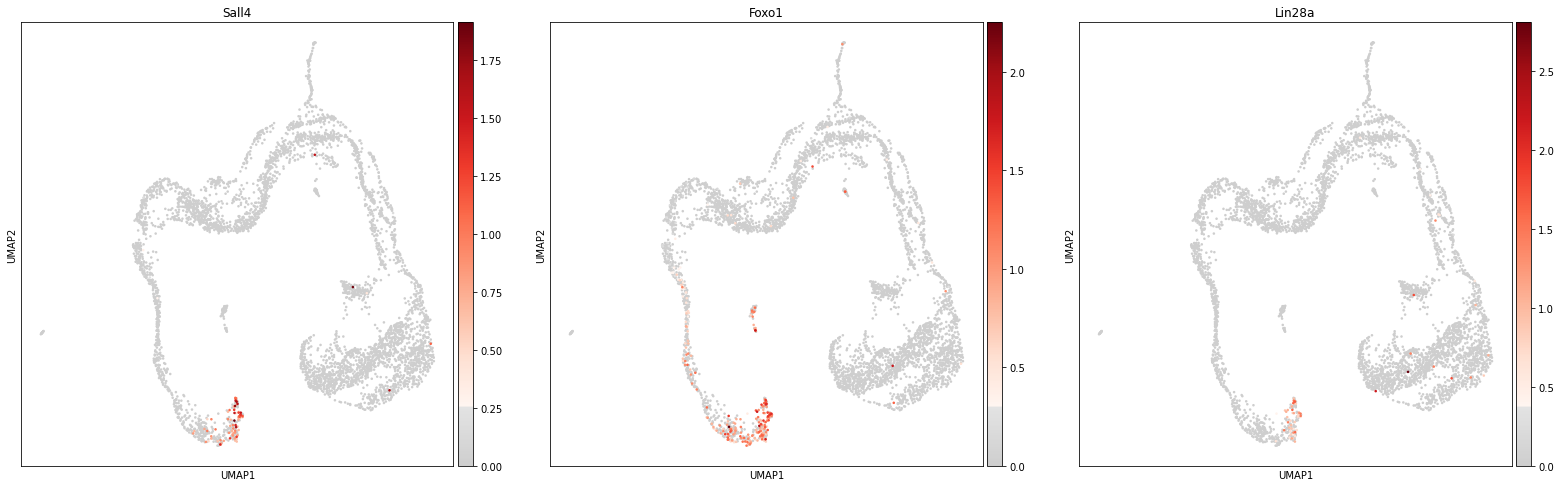

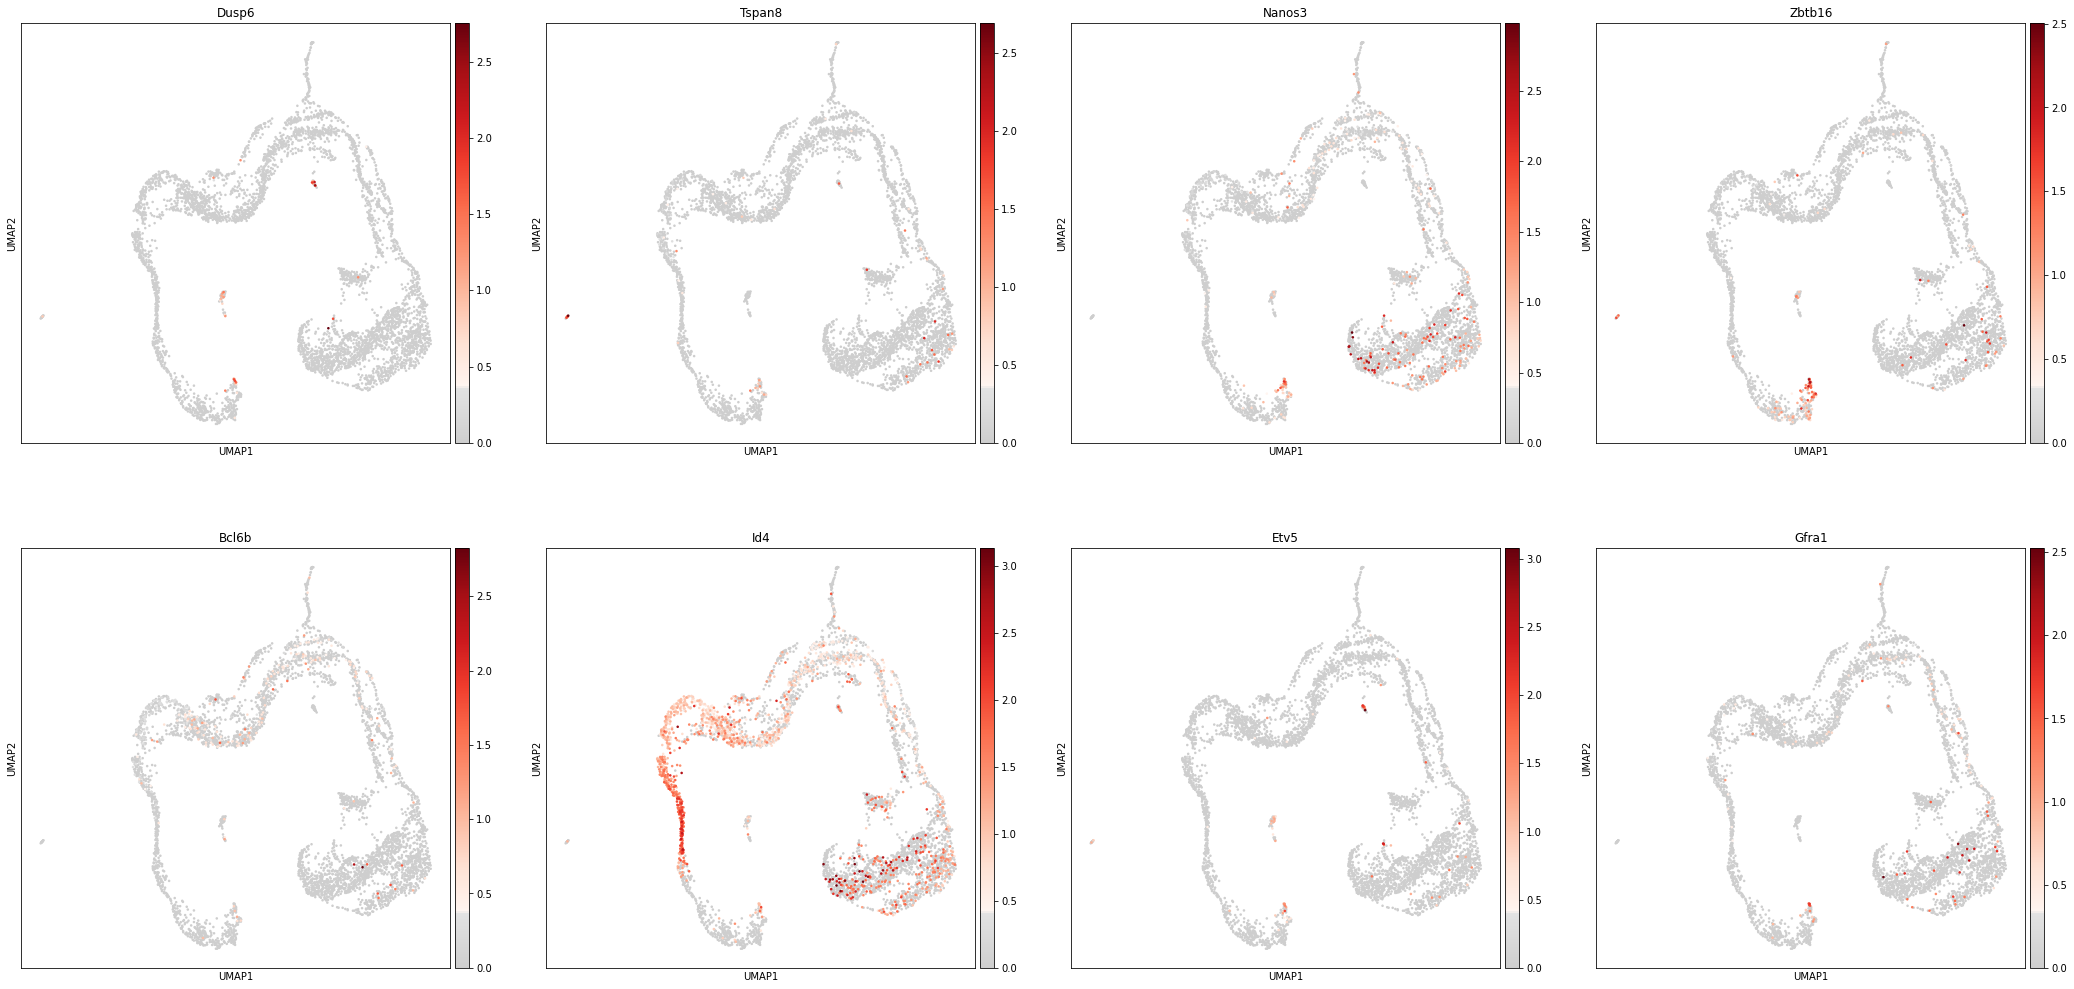

In [64]:
#We can look at the individual markers in each of our assigned groups to see how the expression spreads out over the UMAP
ssc_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['SSC'])]
sc.pl.umap(adata, color=ssc_genes[:3], title=ssc_genes[:3], color_map=mymap)
sc.pl.umap(adata, color=ssc_genes[3:], title=ssc_genes[3:], color_map=mymap)

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


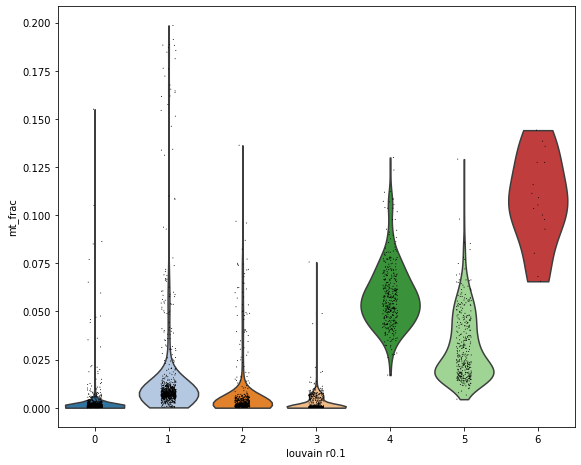

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


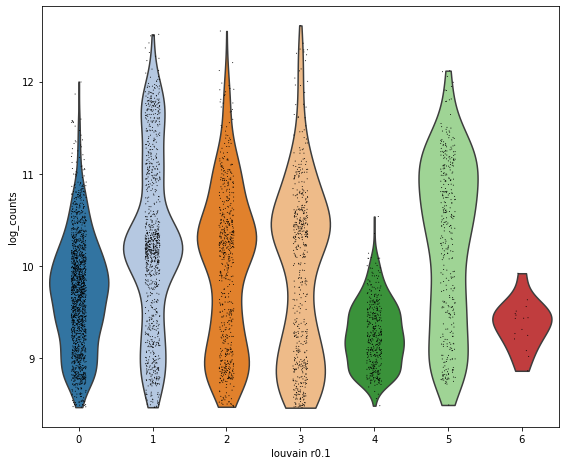

In [65]:
# Lets check the mitochonrial RNA in each group as well as the log counts to see if this is informative about any differences between groups.
sc.pl.violin(adata, 'mt_frac', groupby='louvain_r0.1') #Looks as though the outlier/possibly somatic cell containing group 6 has the higest mitochondrial RNA fraction. This could indicate that role that Sertoli cells are playing by processing sugars into ATP which are then passed to the developing germ cells.
sc.pl.violin(adata, 'log_counts', groupby='louvain_r0.1') #Looks that all of the groups have a similar level of counts except group 4 which contains the  early developing cells which are much more quiescent and thus not as transcriptionally active. 

In [66]:
#Categories to rename now that we have a better idea of which group is which.
adata.obs['louvain_r0.1'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6'], dtype='object')

In [67]:
#Here we rename all the categories with what cell population they are.
adata.rename_categories('louvain_r0.1', ['Late Std', 'Dipl/secondary', 'Early Std', 'Mid Std', 'SSC-Preleptotene', 'Lep-Pachytene Late', 'Somatic'])

In [68]:
adata.obs['louvain_r0.1'].value_counts()

Late Std              1699
Dipl/secondary         995
Early Std              617
Mid Std                531
SSC-Preleptotene       392
Lep-Pachytene Late     364
Somatic                 16
Name: louvain_r0.1, dtype: int64

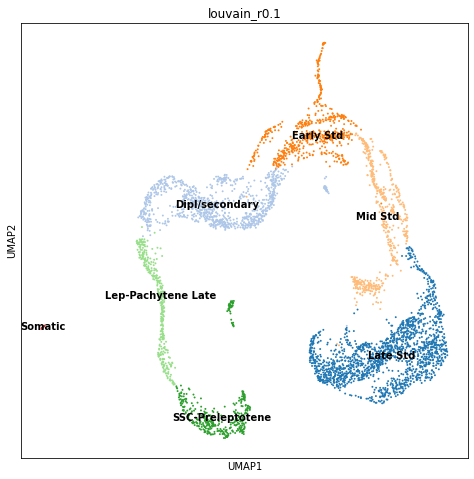

In [69]:
#Now we add this to the UMAP and include the legend on the data.
sc.pl.umap(adata, color='louvain_r0.1', size=15, legend_loc='on data')

In [70]:
#Subcluster SSC-Preleptotene
sc.tl.louvain(adata, restrict_to=('louvain_r0.1', ['SSC-Preleptotene']), resolution=0.25, key_added='louvain_r0.75_SSC-Preleptotene_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain_r0.75_SSC-Preleptotene_sub', the cluster labels (adata.obs, categorical) (0:00:00)


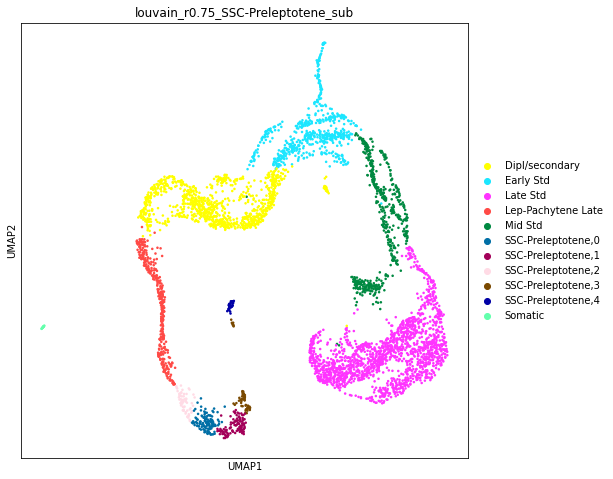

In [71]:
#Show the new clustering
if 'louvain_r0.75_SSC-Preleptotene_sub_colors' in adata.uns:
    del adata.uns['louvain_r0.75_SSC-Preleptotene_sub_colors']

sc.pl.umap(adata, color='louvain_r0.75_SSC-Preleptotene_sub', palette=sc.pl.palettes.godsnot_102)


In [72]:
#Get the new marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.75_SSC-Preleptotene_sub', key_added='rank_genes_r0.75_SSC-Preleptotene_sub')

ranking genes
    finished: added to `.uns['rank_genes_r0.75_SSC-Preleptotene_sub']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


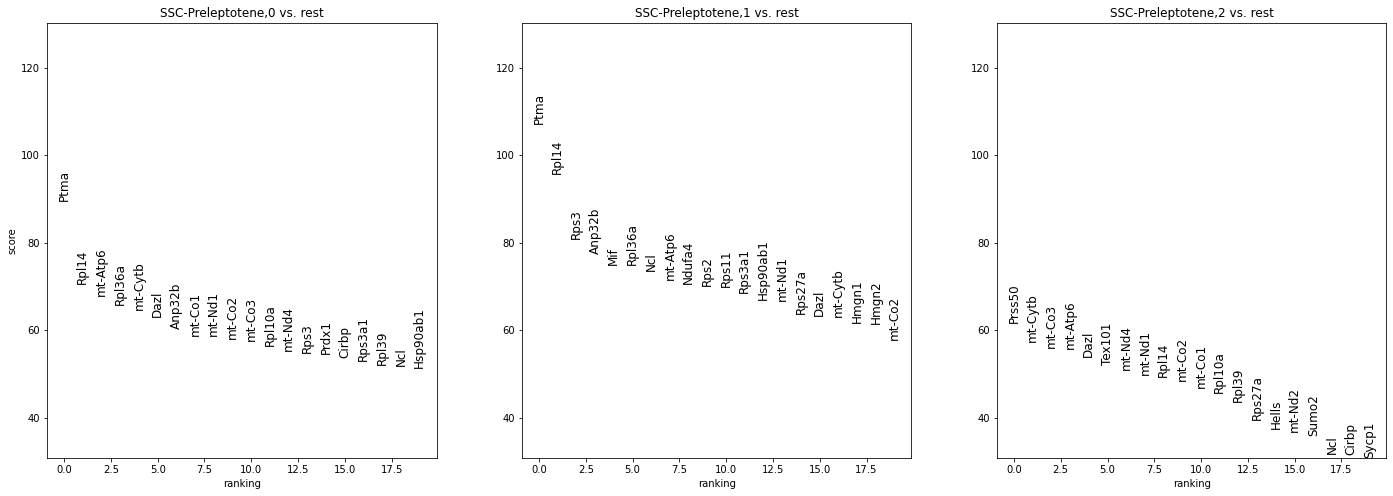

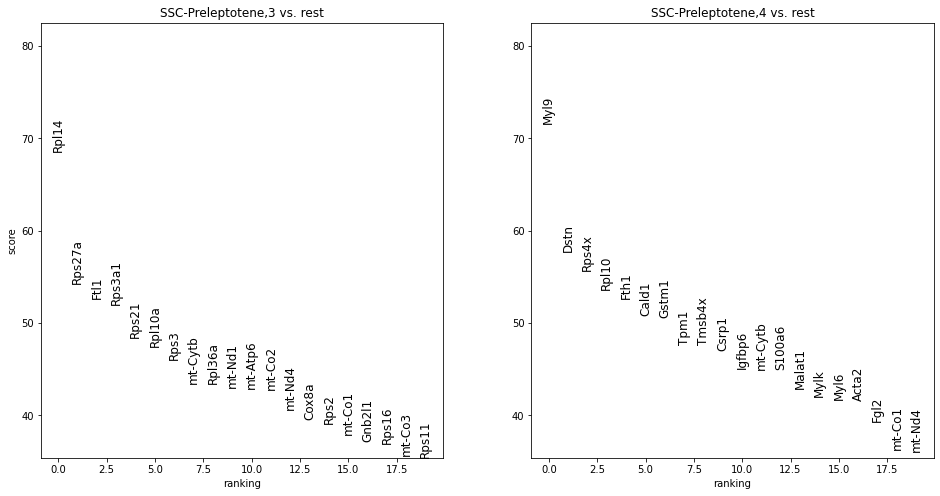

In [73]:
#Plot the new marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.75_SSC-Preleptotene_sub', groups=['SSC-Preleptotene,0', 'SSC-Preleptotene,1', 'SSC-Preleptotene,2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.75_SSC-Preleptotene_sub', groups=['SSC-Preleptotene,3', 'SSC-Preleptotene,4'], fontsize=12)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


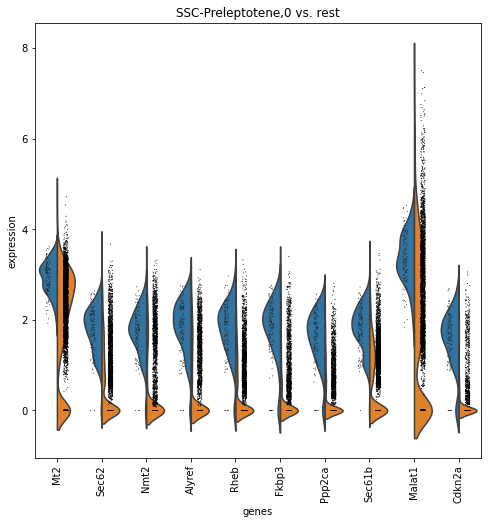

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


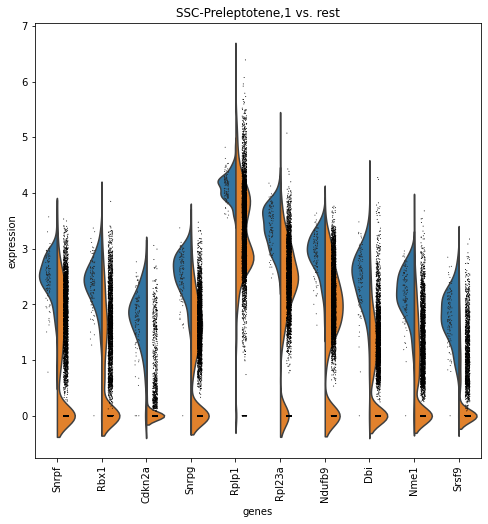

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


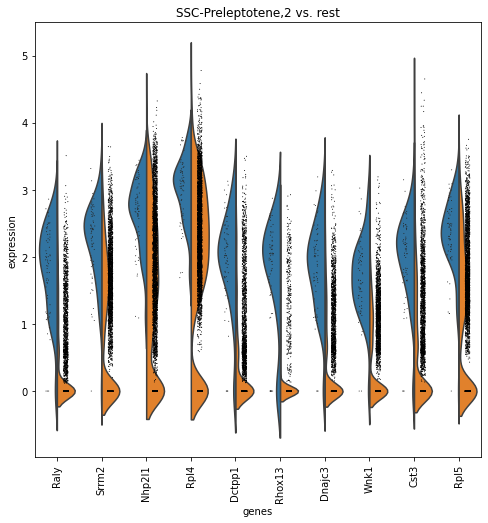

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


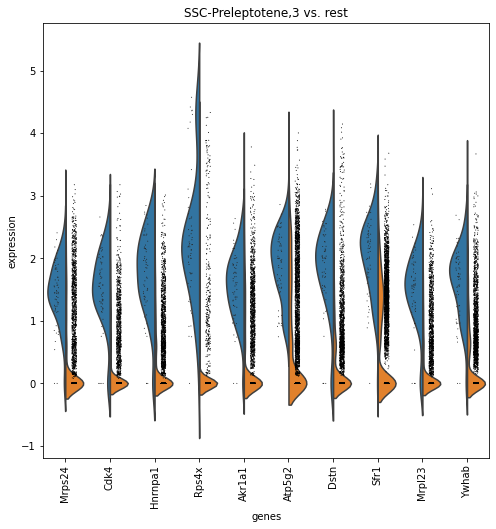

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


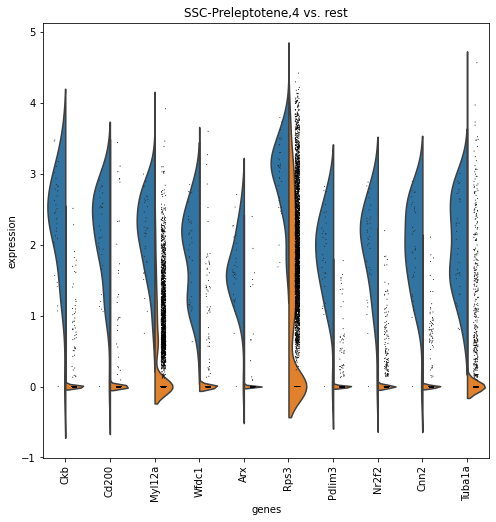

In [74]:
entero_clusts = [clust for clust in adata.obs['louvain_r0.75_SSC-Preleptotene_sub'].cat.categories if clust.startswith('SSC-Preleptotene')]
from scipy import sparse
adata.X = sparse.csc_matrix(adata.X)
for clust in entero_clusts:
    sc.pl.rank_genes_groups_violin(adata, use_raw=False, key='rank_genes_r0.75_SSC-Preleptotene_sub', groups=[clust], gene_names=adata.uns['rank_genes_r0.75_SSC-Preleptotene_sub']['names'][clust][90:100])

In [78]:
#Subset marker gene dictionary to only check for SSC-Prelep markers
key_marker_genes = ['SSC', 'Progenitor Spg', 'Early Diff Spg', 'Late Diff Spg', 'Preleptotene']
sub_marker_genes = {key: marker_genes[key] for key in key_marker_genes}
marker_genes_SSC_Prelep = {k: sub_marker_genes[k] for k in sub_marker_genes}

In [79]:
#Find marker overlap
sc.tl.marker_gene_overlap(adata, marker_genes_SSC_Prelep, key='r', normalize='reference')

ValueError: Could not find marker gene data. Please run `sc.tl.rank_genes_groups()` first.

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


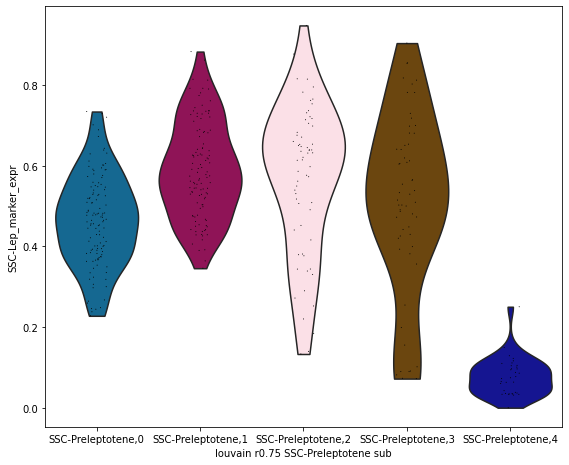

In [80]:

#Check enterocyte marker expression
sc.pl.violin(adata[adata.obs['louvain_r0.1']=='SSC-Preleptotene'], groupby='louvain_r0.75_SSC-Preleptotene_sub', keys='SSC-Lep_marker_expr')

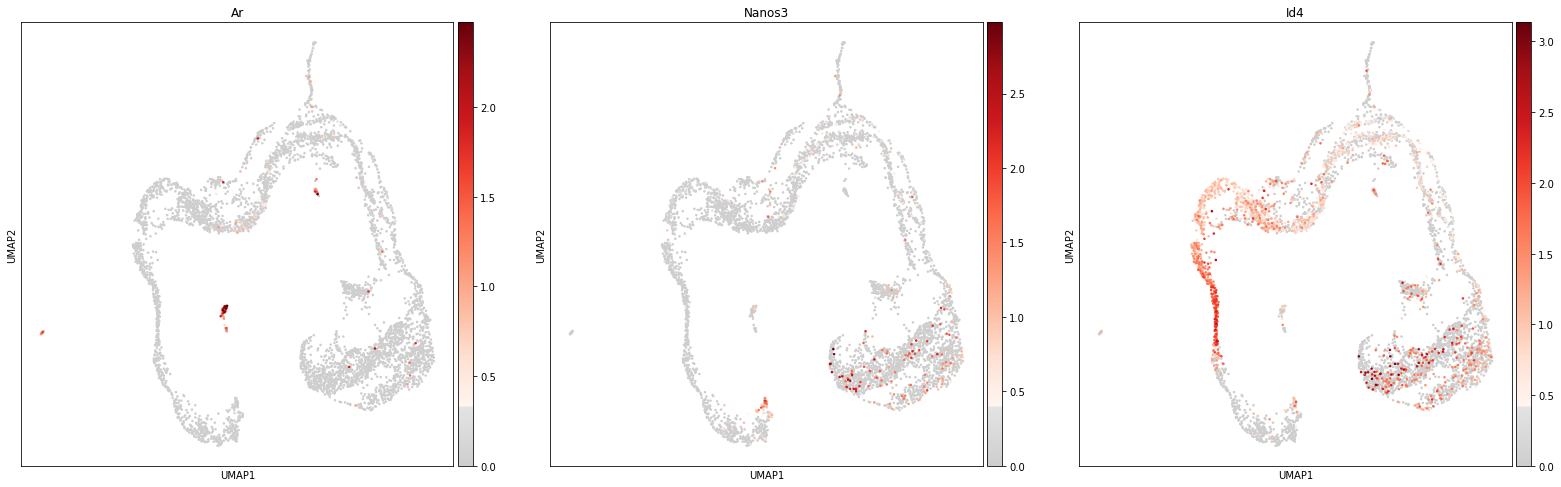

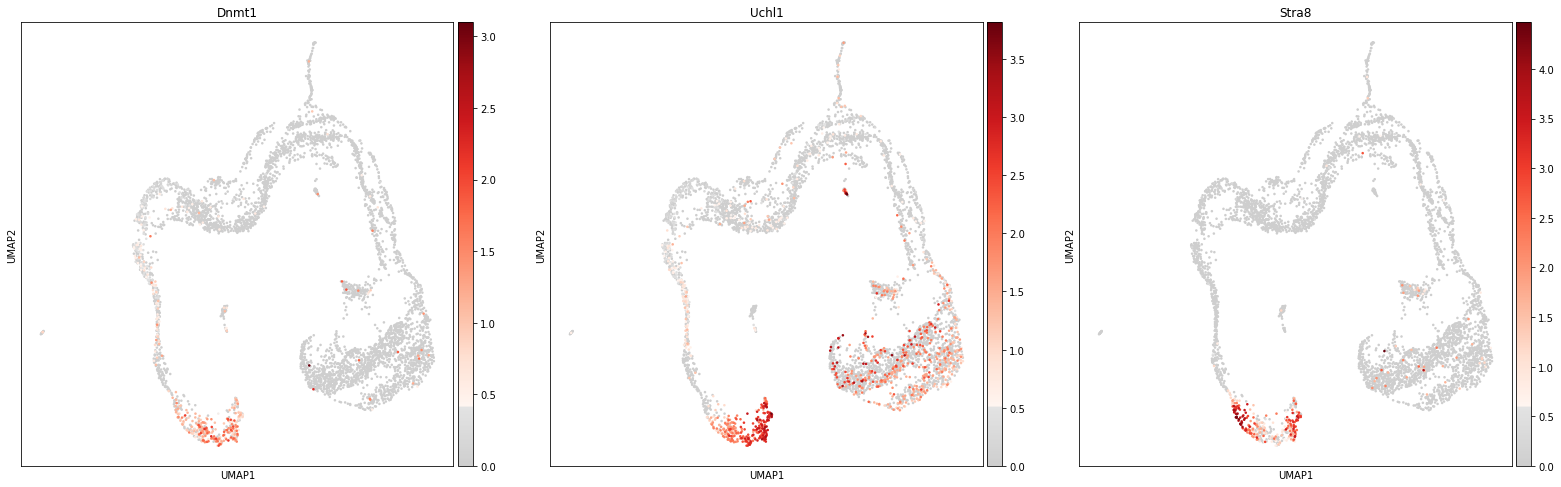

In [81]:
#Visualize some enterocyte markers
entero_genes = ['Ar', 'Nanos3', 'Id4', 'Dnmt1', 'Uchl1', 'Stra8']
sc.pl.umap(adata, color=entero_genes[:3], title=entero_genes[:3], color_map=mymap)
sc.pl.umap(adata, color=entero_genes[3:], title=entero_genes[3:], color_map=mymap)

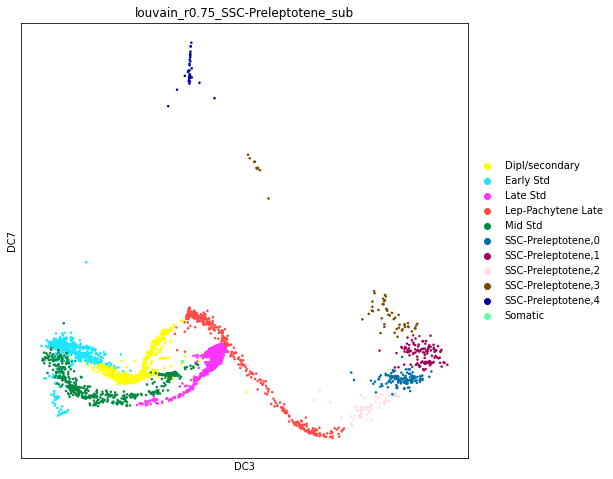

In [83]:
sc.pl.diffmap(adata, color='louvain_r0.75_SSC-Preleptotene_sub', components='3,7')

In [84]:
tmp = adata.obs['louvain_r0.75_SSC-Preleptotene_sub'].cat.categories

tmp = ['Late Diff Spg' if item == 'SSC-Preleptotene,0' else item for item in tmp]
tmp = ['Preleptotene' if item == 'SSC-Preleptotene,1' else item for item in tmp]
tmp = ['Progenitor Spg' if item == 'SSC-Preleptotene,2' else item for item in tmp]
tmp = ['SSC' if item == 'SSC-Preleptotene,3' else item for item in tmp]
tmp = ['Early Diff Spg' if item == 'SSC-Preleptotene,4' else item for item in tmp]
tmp = ['Sertoli' if item == 'SSC-Preleptotene,5' else item for item in tmp]


adata.rename_categories('louvain_r0.75_SSC-Preleptotene_sub', tmp)

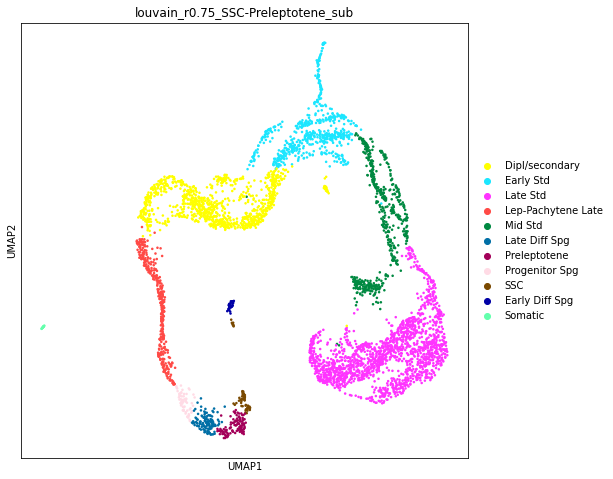

In [85]:
#Show the new clustering
if 'louvain_r0.75_SSC-Preleptotene_sub_colors' in adata.uns:
    del adata.uns['louvain_r0.75_SSC-Preleptotene_sub_colors']

sc.pl.umap(adata, color='louvain_r0.75_SSC-Preleptotene_sub', palette=sc.pl.palettes.godsnot_102)

In [86]:
#Subcluster SSC-Preleptotene
sc.tl.louvain(adata, restrict_to=('louvain_r0.75_SSC-Preleptotene_sub', ['Lep-Pachytene Late']), resolution=0.25, key_added='louvain_r0.25_Lep-Pachytenee_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain_r0.25_Lep-Pachytenee_sub', the cluster labels (adata.obs, categorical) (0:00:00)


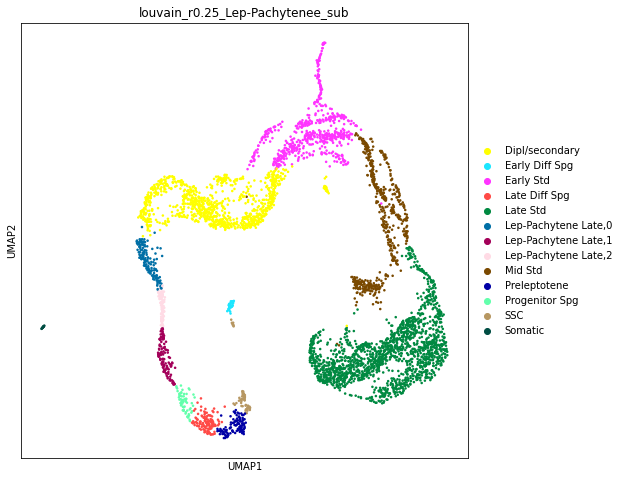

In [87]:
#Show the new clustering
if 'louvain_r0.25_Lep-Pachytenee_sub_colors' in adata.uns:
    del adata.uns['louvain_r0.25_Lep-Pachytenee_sub_colors']

sc.pl.umap(adata, color='louvain_r0.25_Lep-Pachytenee_sub', palette=sc.pl.palettes.godsnot_102)

In [88]:
tmp = adata.obs['louvain_r0.25_Lep-Pachytenee_sub'].cat.categories

tmp = ['Pachytene Late' if item == 'Lep-Pachytene Late,0' else item for item in tmp]
tmp = ['Lep-Zyg Early Pach' if item == 'Lep-Pachytene Late,1' else item for item in tmp]
tmp = ['Pachytene Mid' if item == 'Lep-Pachytene Late,2' else item for item in tmp]

adata.rename_categories('louvain_r0.25_Lep-Pachytenee_sub', tmp)

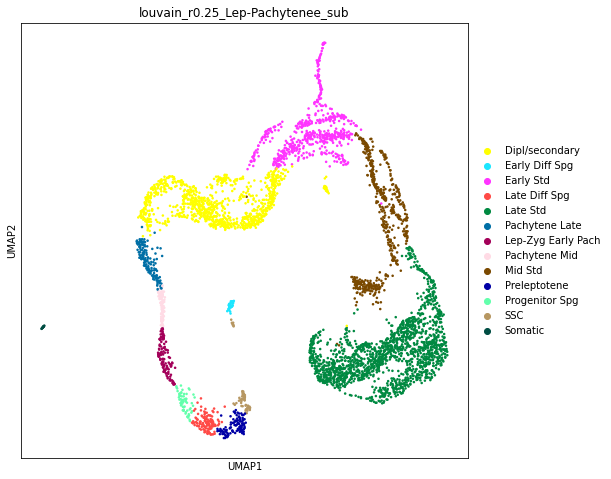

In [89]:
#Show the new clustering
if 'louvain_r0.25_Lep-Pachytenee_sub_colors' in adata.uns:
    del adata.uns['louvain_r0.25_Lep-Pachytenee_sub_colors']

sc.pl.umap(adata, color='louvain_r0.25_Lep-Pachytenee_sub', palette=sc.pl.palettes.godsnot_102)

In [90]:
adata.obs['louvain_final'] = adata.obs['louvain_r0.25_Lep-Pachytenee_sub']

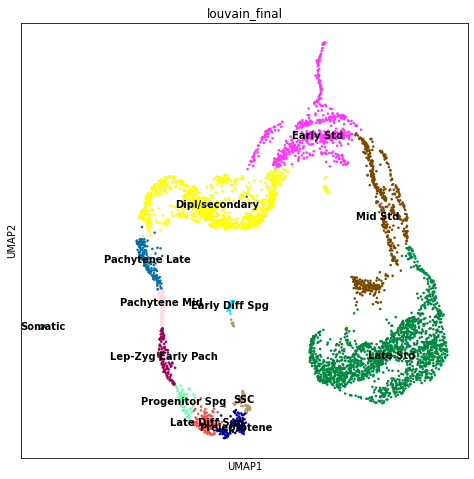

In [114]:
sc.pl.umap(adata, color='louvain_final', palette=sc.pl.palettes.godsnot_102, legend_loc='on data')

In [92]:
adata.obs['louvain_final'].value_counts()

Late Std              1699
Dipl/secondary         995
Early Std              617
Mid Std                531
Pachytene Late         157
Late Diff Spg          124
Lep-Zyg Early Pach     119
Preleptotene           113
Pachytene Mid           88
Progenitor Spg          63
SSC                     58
Early Diff Spg          34
Somatic                 16
Name: louvain_final, dtype: int64

In [93]:
adata.obs['louvain_final'].value_counts()

Late Std              1699
Dipl/secondary         995
Early Std              617
Mid Std                531
Pachytene Late         157
Late Diff Spg          124
Lep-Zyg Early Pach     119
Preleptotene           113
Pachytene Mid           88
Progenitor Spg          63
SSC                     58
Early Diff Spg          34
Somatic                 16
Name: louvain_final, dtype: int64

In [94]:
#Subsetting to relevant clusters

clusters_to_include = [g for g in adata.obs['louvain_final'].cat.categories if (g.startswith('SSC') or g.startswith('Progenitor Spg') or g.startswith('Early Diff Spg') or g.startswith('Late Diff Spg') or g.startswith('Preleptotene'))]
adata_ent = adata[np.isin(adata.obs['louvain_final'], clusters_to_include),:].copy()

#Subset to highly variable genes
sc.pp.highly_variable_genes(adata_ent, flavor='cell_ranger', n_top_genes=4000, subset=True)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


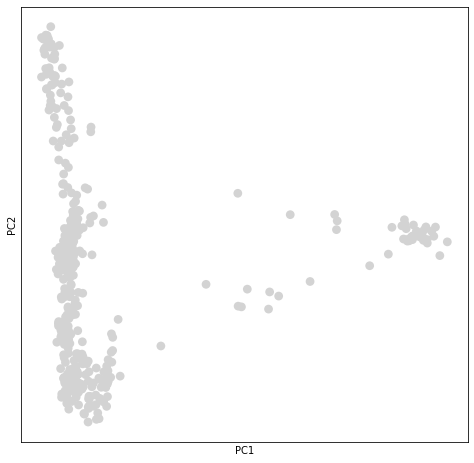

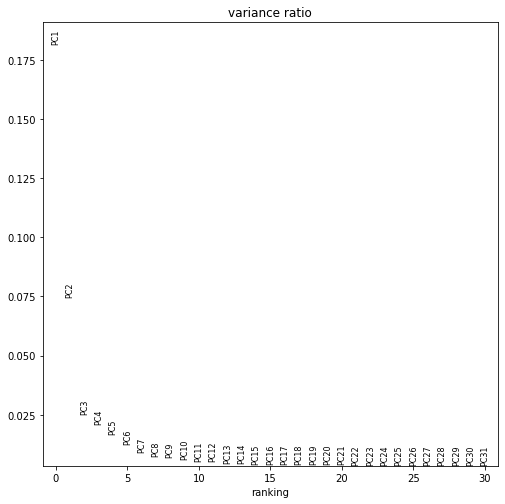

In [95]:
#Recalculating PCA for subset
sc.pp.pca(adata_ent, svd_solver='arpack')
sc.pl.pca(adata_ent)
sc.pl.pca_variance_ratio(adata_ent)

In [96]:
adata_ent.obsm['X_pca'] = adata_ent.obsm['X_pca'][:,0:7]

In [113]:
%%R -i adata_ent

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(adata_ent)$PCA[,1], reducedDims(adata_ent)$PCA[,2], col=colour_map[colData(adata_ent)$louvain_final], bty='L', xlab='PC1', ylab='PC2')
legend(x=12, y=12, legend=unique(colData(adata_ent)$louvain_final), fill=colour_map[as.integer(unique(colData(adata_ent)$louvain_final))])

print("1:")
adata_ent_start <- slingshot(adata_ent, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='SSC')
print(SlingshotDataSet(adata_ent_start))

print("")
print("2:")
adata_ent_startend <- slingshot(adata_ent, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='SSC', end.clus=c('Early Diff Spg'))
print(SlingshotDataSet(adata_ent_startend))

print("")
print("3:")
adata_ent_simple_startend <- slingshot(adata_ent, clusterLabels = 'louvain_r0.1', reducedDim = 'PCA', start.clus='SSC-Preleptotene', end.clus='Lep-Pachytene Late')
print(SlingshotDataSet(adata_ent_simple_startend))

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
     392          7

lineages: 2 
Lineage1: SSC  Preleptotene  Late Diff Spg  Progenitor Spg  
Lineage2: SSC  Early Diff Spg  

curves: 2 
Curve1: Length: 48.048	Samples: 340.26
Curve2: Length: 81.93	Samples: 84.42
[1] ""
[1] "2:"
class: SlingshotDataSet 

 Samples Dimensions
     392          7

lineages: 2 
Lineage1: SSC  Preleptotene  Late Diff Spg  Progenitor Spg  
Lineage2: SSC  Early Diff Spg  

curves: 2 
Curve1: Length: 48.048	Samples: 340.26
Curve2: Length: 81.93	Samples: 84.42
[1] ""
[1] "3:"

Error in X[, tree] : subscript out of bounds


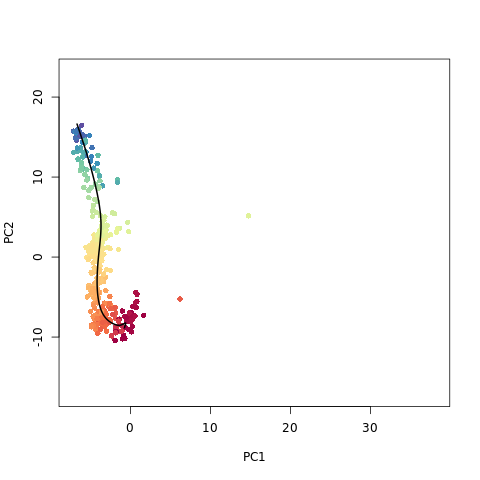

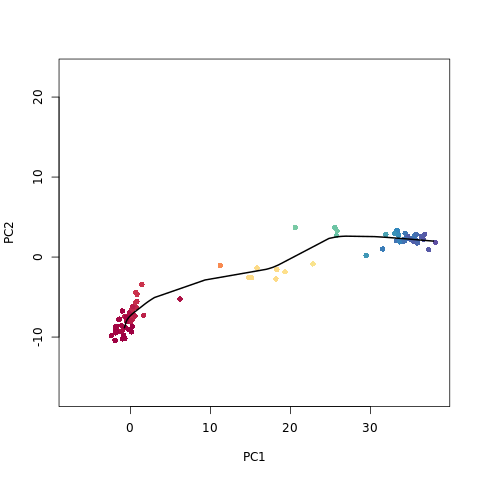

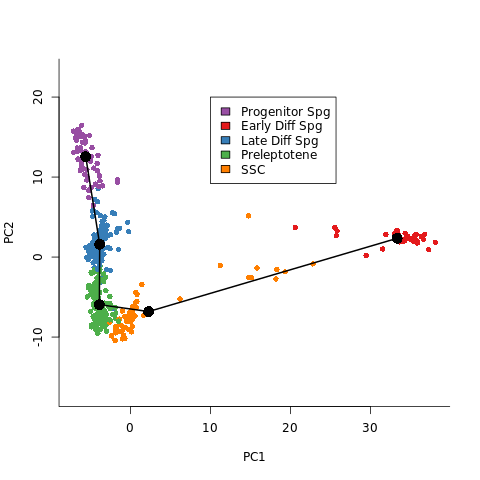

In [99]:
%%R

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_startend)$PCA[,c(1,2)], col = colors[cut(adata_ent_startend$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_ent_startend)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_startend)$PCA[,c(1,2)], col = colors[cut(adata_ent_startend$slingPseudotime_2,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_ent_startend)$curve2, lwd=2)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
plot(reducedDims(adata_ent_startend)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata_ent$louvain_final], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_startend), lwd=2, type='lineages')
legend(x=10, y=20, legend=unique(colData(adata_ent)$louvain_final), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata_ent)$louvain_final))])

In [87]:
%%R

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_startend)$PCA[,c(1,2)], col = colors[cut(adata_ent_startend$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_ent_startend)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_startend)$PCA[,c(1,2)], col = colors[cut(adata_ent_startend$slingPseudotime_2,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_ent_startend)$curve2, lwd=2)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
plot(reducedDims(adata_ent_startend)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata_ent$louvain_final], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_startend), lwd=2, type='lineages')
legend(x=10, y=20, legend=unique(colData(adata_ent)$louvain_final), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata_ent)$louvain_final))])

#Plot of simpler clustering
plot(reducedDims(adata_ent_simple_startend)$PCA[,c(1,2)], col = colors[cut(adata_ent_simple_startend$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_simple_startend), lwd=2)


Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'plot': error in evaluating the argument 'x' in selecting a method for function 'reducedDims': object 'adata_ent_simple_startend' not found


In [100]:
#Subsetting data set - non-batch corrected
cell_mask = np.isin(adata.obs['louvain_final'], clusters_to_include)
adata_ent_nbc = sc.AnnData(X = adata.raw.X[cell_mask,:])
adata_ent_nbc.obs = adata.obs[cell_mask]
adata_ent_nbc.var = adata.var.copy()

#Subset to highly variable genes
sc.pp.highly_variable_genes(adata_ent_nbc, flavor='cell_ranger', n_top_genes=4000, subset=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


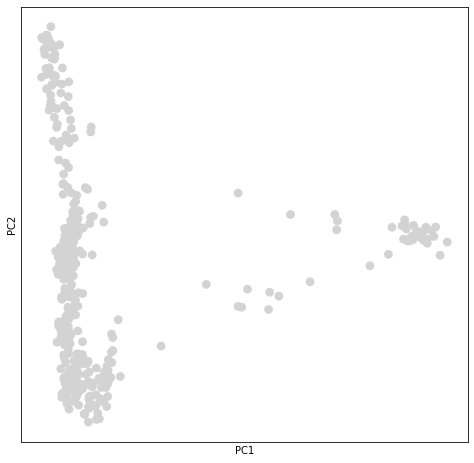

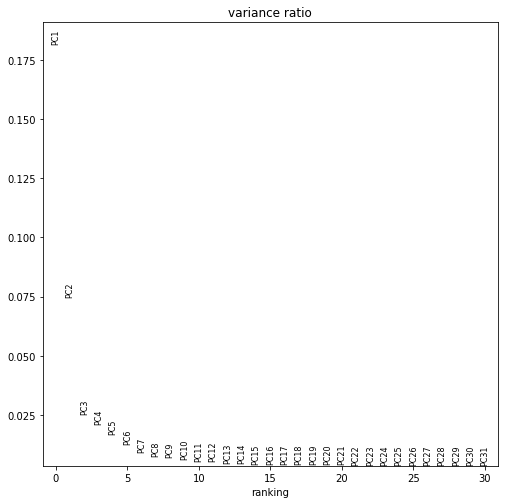

In [101]:
#Recalculating PCA for subset
sc.pp.pca(adata_ent_nbc, svd_solver='arpack')
sc.pl.pca(adata_ent_nbc)
sc.pl.pca_variance_ratio(adata_ent_nbc)

In [103]:
adata_ent_nbc.obsm['X_pca'] = adata_ent_nbc.obsm['X_pca'][:,0:7]

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
     392          7

lineages: 2 
Lineage1: SSC  Preleptotene  Late Diff Spg  Progenitor Spg  
Lineage2: SSC  Early Diff Spg  

curves: 2 
Curve1: Length: 48.591	Samples: 343.8
Curve2: Length: 81.131	Samples: 83.77
[1] ""
[1] "2:"
class: SlingshotDataSet 

 Samples Dimensions
     392          7

lineages: 2 
Lineage1: SSC  Preleptotene  Late Diff Spg  Progenitor Spg  
Lineage2: SSC  Early Diff Spg  

curves: 2 
Curve1: Length: 48.591	Samples: 343.8
Curve2: Length: 81.131	Samples: 83.77


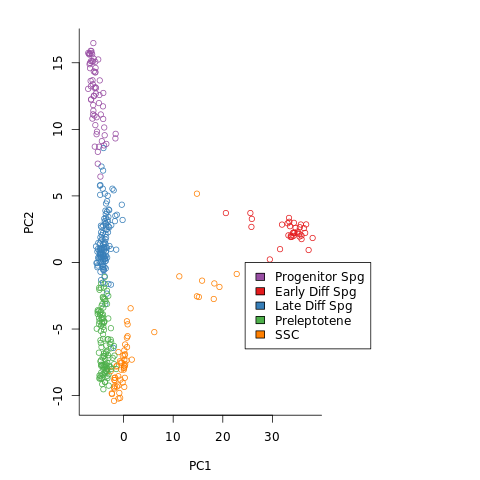

In [104]:
%%R -i adata_ent_nbc

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,11))
plot(reducedDims(adata_ent_nbc)$PCA[,1], reducedDims(adata_ent_nbc)$PCA[,2], col=colour_map[colData(adata_ent_nbc)$louvain_final], bty='L', xlab='PC1', ylab='PC2')
legend(x=24.5, y=0, legend=unique(colData(adata_ent_nbc)$louvain_final), fill=colour_map[as.integer(unique(colData(adata_ent_nbc)$louvain_final))])

#First trajectory: only Stem cells set as root cells
print("1:")
adata_ent_start_nbc <- slingshot(adata_ent_nbc, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='SSC')
print(SlingshotDataSet(adata_ent_start_nbc))

#Second trajectory: Stem cells as root cells and mature enterocytes as end clusters
print("")
print("2:")
adata_ent_startend_nbc <- slingshot(adata_ent_nbc, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='SSC', end.clus=c('Progenitor Spg'))
print(SlingshotDataSet(adata_ent_startend_nbc))


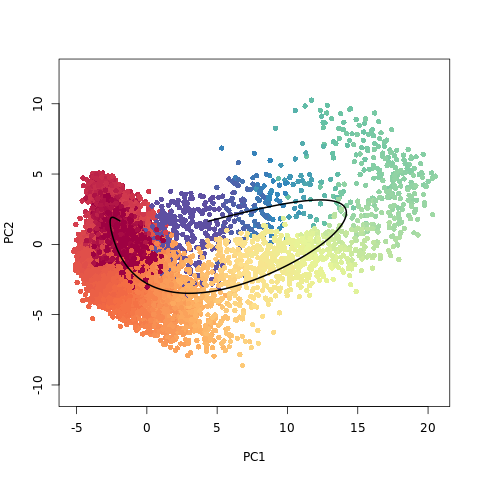

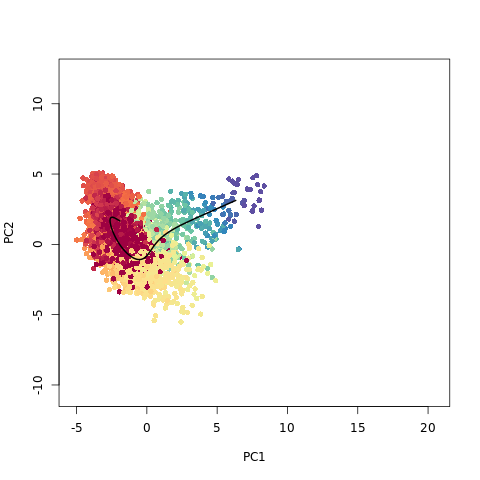

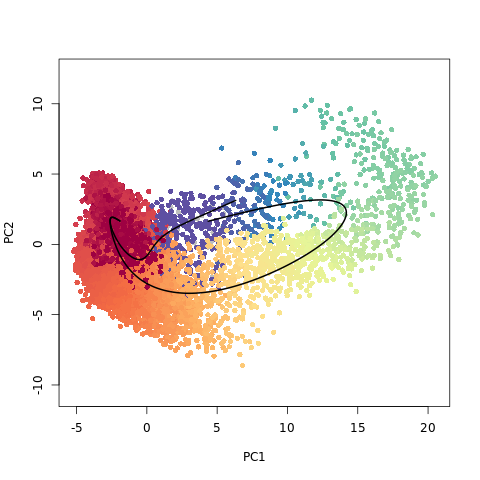

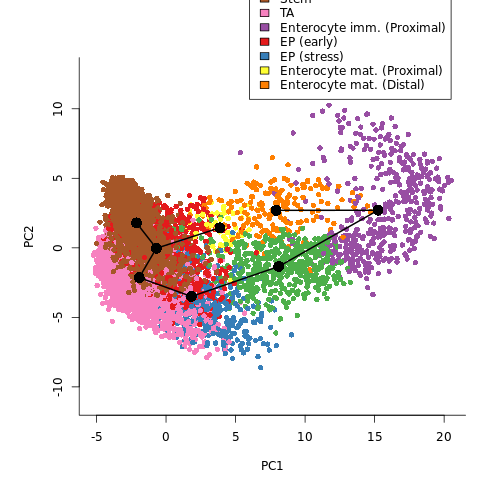

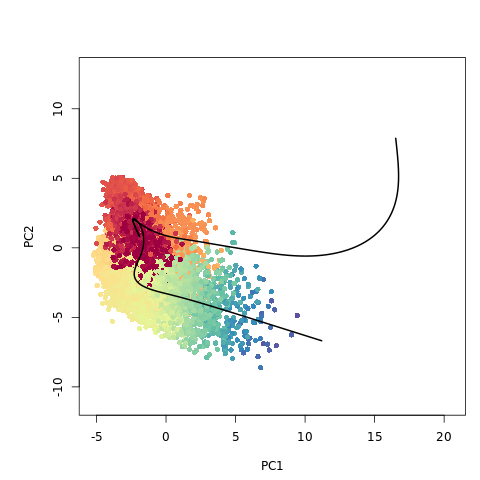

In [86]:
%%R

colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)

#Plot of lineage 1
plot(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], 
     col = colors[cut(adata_ent_startend_nbc$slingPseudotime_1,breaks=100)], 
     pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_ent_startend_nbc)$curve1, lwd=2)

#Plot of lineage 2
plot(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], 
     col = colors[cut(adata_ent_startend_nbc$slingPseudotime_2,breaks=100)], 
     pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_ent_startend_nbc)$curve2, lwd=2)

#Combined plot
plot(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], col = 'grey', 
     pch=16, asp = 1, size=0.8, xlab='PC1', ylab='PC2')
points(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], 
       col = colors[cut(adata_ent_startend_nbc$slingPseudotime_1,breaks=100)], 
       pch=16, size=1)
lines(slingCurves(adata_ent_startend_nbc)$curve1, lwd=2)
lines(slingCurves(adata_ent_startend_nbc)$curve2, lwd=2)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
par(mar=c(4.5,5.5,4,1))
plot(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], 
     col = brewer.pal(11,'Set1')[adata_ent_startend_nbc$louvain_final], 
     pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_startend_nbc), lwd=2, type='lineages')
legend(x=6, y=20, legend=unique(colData(adata_ent_nbc)$louvain_final), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata_ent_nbc)$louvain_final))])

#Plot of simpler clustering
plot(reducedDims(adata_ent_simple_startend_nbc)$PCA[,c(1,2)], 
     col = colors[cut(adata_ent_simple_startend_nbc$slingPseudotime_1,breaks=100)], 
     pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_simple_startend_nbc), lwd=2)

In [105]:
sc.pp.neighbors(adata_ent)
sc.tl.diffmap(adata_ent)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9943856  0.9928286  0.98886627 0.9813677  0.9651916
     0.9642973  0.9507139  0.93622345 0.9356388  0.90538245 0.90306354
     0.8848417  0.87905973 0.86513954]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


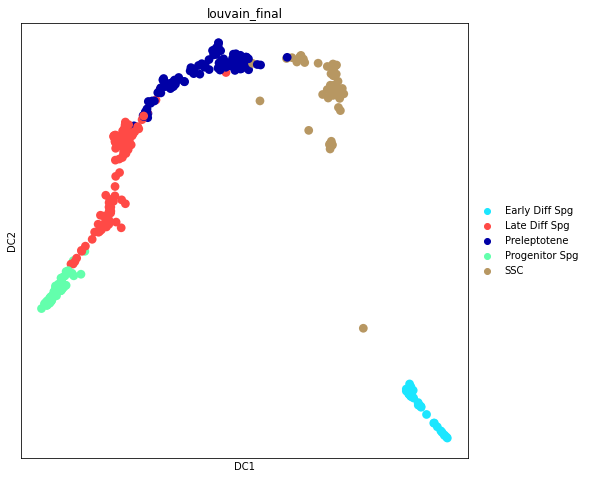

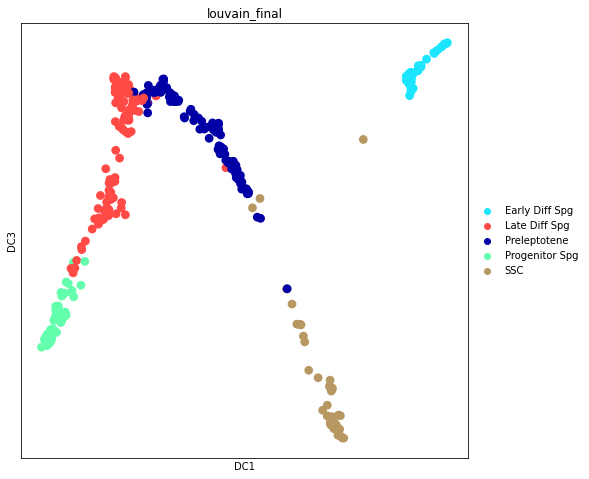

In [106]:
sc.pl.diffmap(adata_ent, components='1,2', color='louvain_final')
sc.pl.diffmap(adata_ent, components='1,3', color='louvain_final')

In [107]:
#Find the stem cell with the highest DC3 value to act as root for the diffusion pseudotime and compute DPT
stem_mask = np.isin(adata_ent.obs['louvain_final'], 'Stem')
max_stem_id = np.argmin(adata_ent.obsm['X_diffmap'][stem_mask,3])
root_id = np.arange(len(stem_mask))[stem_mask][max_stem_id]
adata_ent.uns['iroot'] = root_id

#Compute dpt
sc.tl.dpt(adata_ent)

ValueError: attempt to get argmin of an empty sequence

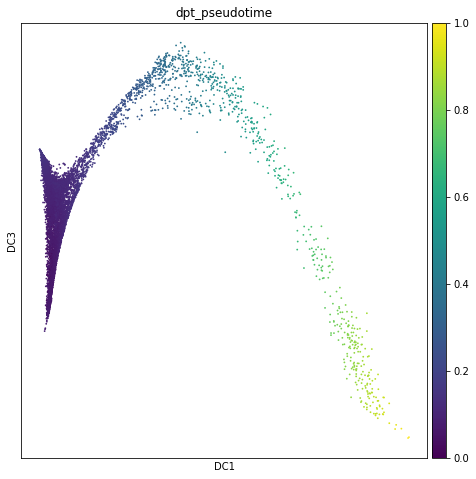

In [90]:
#Visualize pseudotime over differentiation
sc.pl.diffmap(adata_ent, components='1,3', color='dpt_pseudotime')

In [91]:
%%R

#Set the pseudotime variable
t <- adata_ent_simple_startend$slingPseudotime_1

#Extract the gene expression matrix
Y <- assay(adata_ent_simple_startend)

# fit a GAM with a loess term for pseudotime
#Note: This takes a while
gam.pval <- apply(Y,1,function(z){
  d <- data.frame(z=z, t=t)
  tmp <- gam(z ~ lo(t), data=d)
  p <- summary(tmp)[4][[1]][1,5]
  p
})

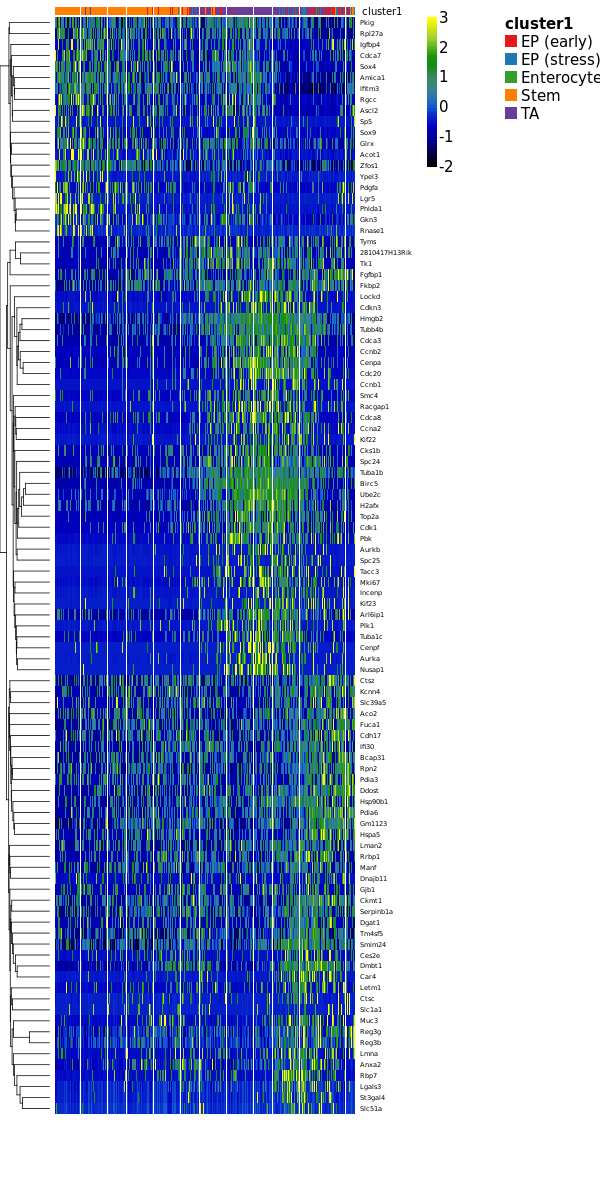

In [92]:
%%R -w 600 -h 1200

#Select the top 100 most significant genes that change over pseudotime
topgenes <- names(sort(gam.pval, decreasing = FALSE))[1:100]
heatdata <- assay(adata_ent_simple_startend)[rownames(assay(adata_ent_simple_startend)) %in% topgenes, 
                        order(t, na.last = NA)]

#Scale the data per gene for visualization
heatdata <- t(scale(t(heatdata)))

#Trimm z-score scale
heatdata[heatdata > 3] = 3
heatdata[heatdata < -3] = -3

#Get cluster assignment
heatclus <- adata_ent_simple_startend$louvain_r0.5[order(t, na.last = NA)]

#Set up a clusterExperiment data structure for heatmap visualization
ce <- ClusterExperiment(heatdata, heatclus, transformation = function(x){x})

#Plot the heatmap
plotHeatmap(ce, clusterSamplesData = "orderSamplesValue", visualizeData = 'transformed', fontsize=15)

In [93]:
entero_markers = marker_genes['Enterocyte (Proximal)'] + marker_genes['Enterocyte (Distal)']

In [95]:
%%R -i entero_markers
print(rownames(heatdata)[rownames(heatdata) %in% entero_markers])

[1] "Ckmt1"  "Muc3"   "Anxa2"  "Slc51a"


In [96]:
%%R

pt1 <- adata_ent_startend_nbc$slingPseudotime_1
clustDat <- adata_ent_startend_nbc$louvain_final

#Subset data to only include cells on lineage 1
clustDat <- clustDat[!is.na(pt1)]
pt1 <- pt1[!is.na(pt1)]
df = data.frame(clusters = clustDat, pt = pt1)

#Bin clusters in same way as pseudotime:
bin_width = 0.5
max_bin = ceiling(max(df$pt)*2)/2
df['bins'] = cut(df$pt, breaks=seq(-bin_width/2, max_bin, bin_width))

#Find dominant cluster in each bin
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

dominant_clusters = sapply(levels(df$bins), function(x){Mode(df$clust[df$bins==x])})
levels(dominant_clusters) <- c(levels(dominant_clusters), 'None')
dominant_clusters[is.na(dominant_clusters)] <- 'None'

#Define colour map
cmap <- brewer.pal(11,'Set1')

#Plot meta-stable states
p <- qplot(adata_ent_startend_nbc$slingPseudotime_1, geom='histogram', main='Cellular density over trajectory', xlab='Pseudotime', binwidth=bin_width, fill=I(cmap[dominant_clusters])) +
theme_bw() +
scale_colour_manual(name="Cluster", values=c('EP (Distal)'=cmap[levels(dominant_clusters)[1]], 'EP (early)'=cmap[levels(dominant_clusters)[2]], EP_early="purple"))
print(p)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,1))
plot(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata_ent$louvain_final], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_startend_nbc), lwd=2, type='lineages')
legend(x=10, y=20, legend=unique(colData(adata_ent)$louvain_final), fill=cmap[as.integer(unique(colData(adata_ent)$louvain_final))])


Error: Aesthetics must be either length 1 or the same as the data (82): fill
Run `rlang::last_error()` to see where the error occurred.


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


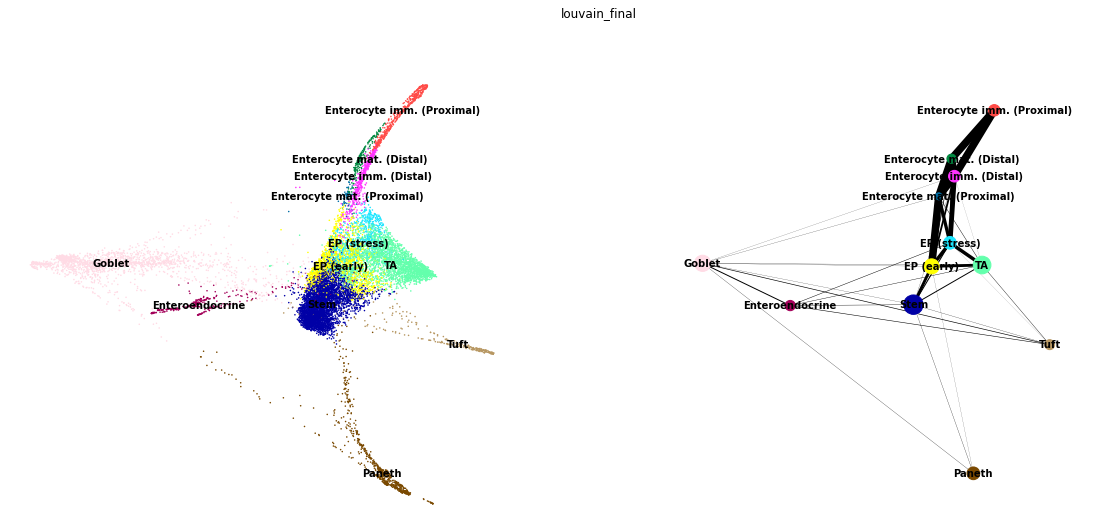

--> added 'pos', the PAGA positions (adata.uns['paga'])


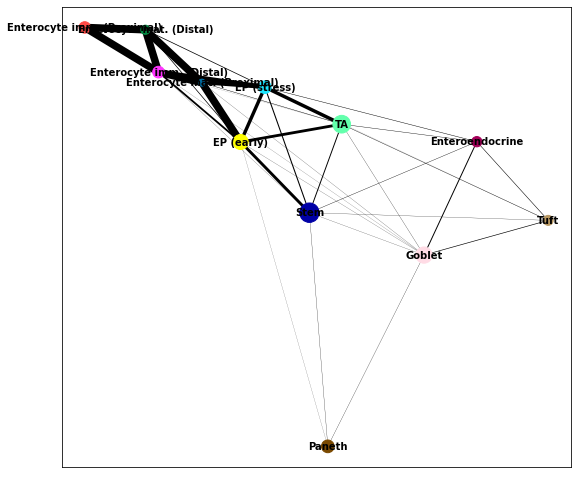

In [97]:
sc.tl.paga(adata, groups='louvain_final')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


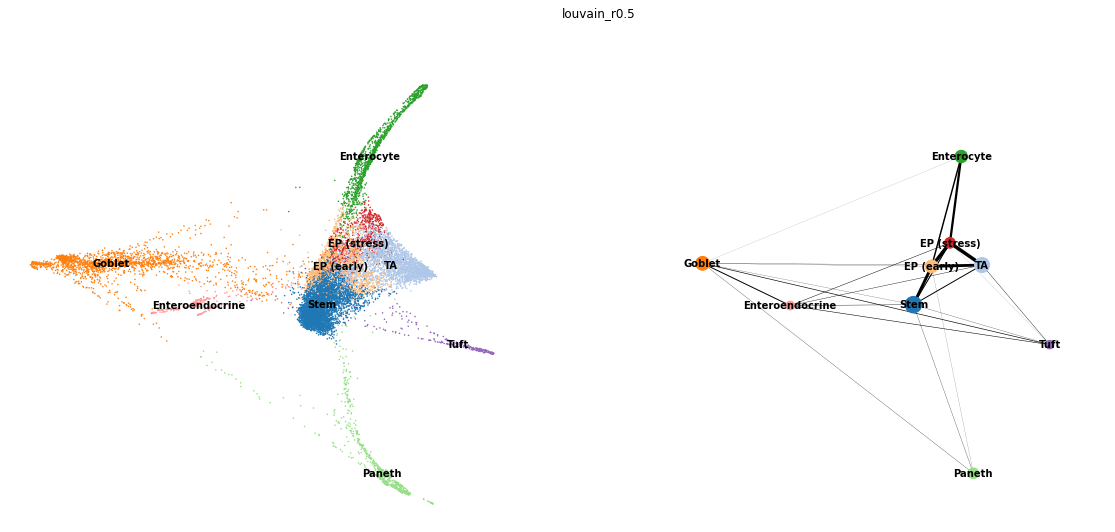

--> added 'pos', the PAGA positions (adata.uns['paga'])


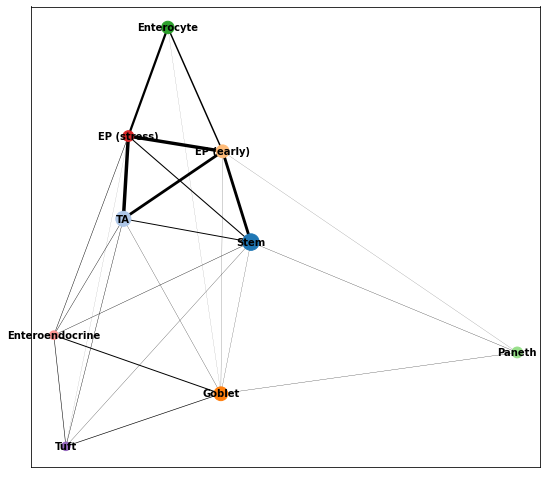

In [98]:
sc.tl.paga(adata, groups='louvain_r0.5')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

--> added 'pos', the PAGA positions (adata.uns['paga'])


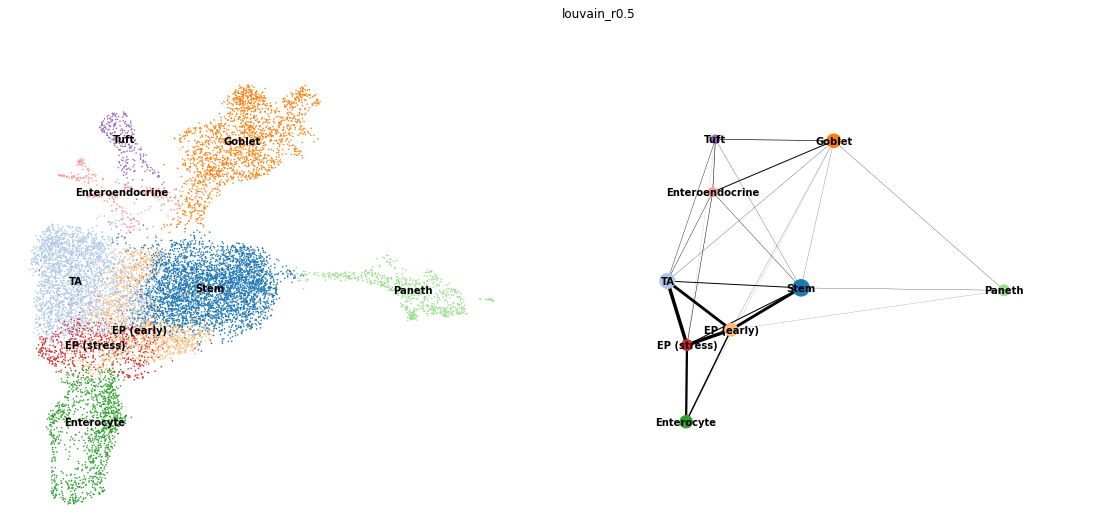

In [99]:
sc.pl.paga_compare(adata, basis='umap')

--> added 'pos', the PAGA positions (adata.uns['paga'])


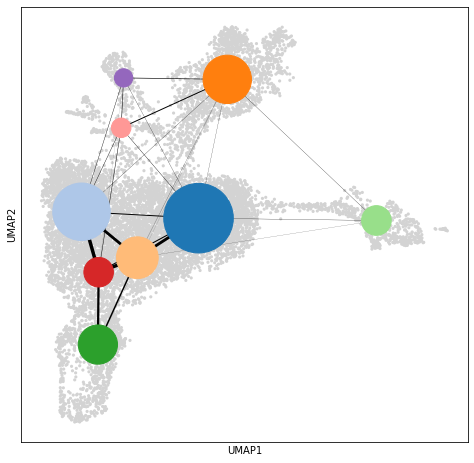

In [100]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata, pos=adata.uns['paga']['pos'], show=False, node_size_scale=10, node_size_power=1, ax=ax1, text_kwds={'alpha':0})
#plt.savefig('./figures/umap_paga_overlay_gut.pdf', dpi=300, format='pdf')
plt.show()

In [101]:
#Create new Anndata object with non-batch corrected data
adata_test = adata.copy()
adata_test.X = adata.raw.X

In [102]:
#Regress out counts and redo pre-processing
sc.pp.regress_out(adata_test, 'n_counts')
sc.pp.pca(adata_test, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_test)

regressing out n_counts
    finished (0:04:04)
computing PCA
    on highly variable genes
    with n_comps=50


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


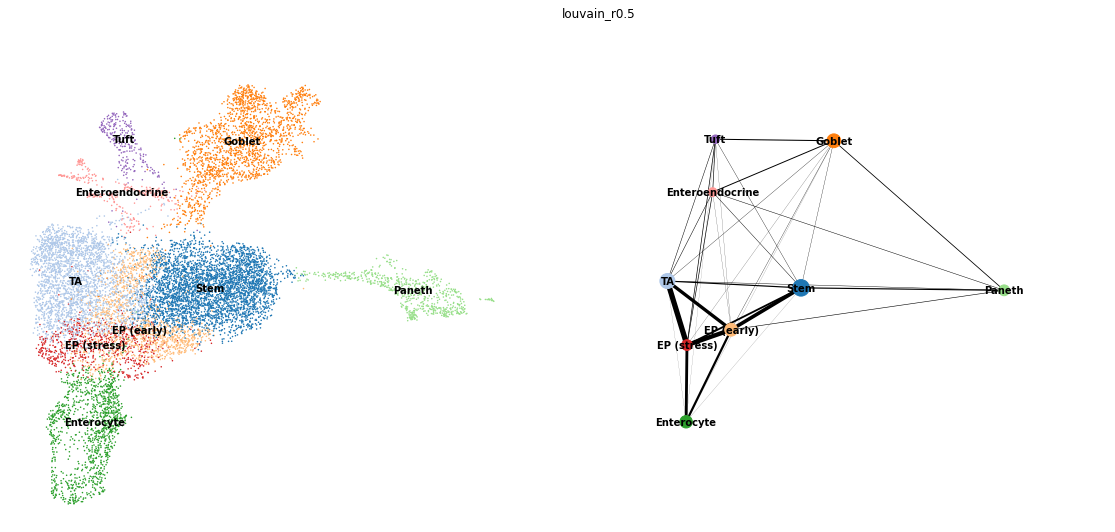

--> added 'pos', the PAGA positions (adata.uns['paga'])


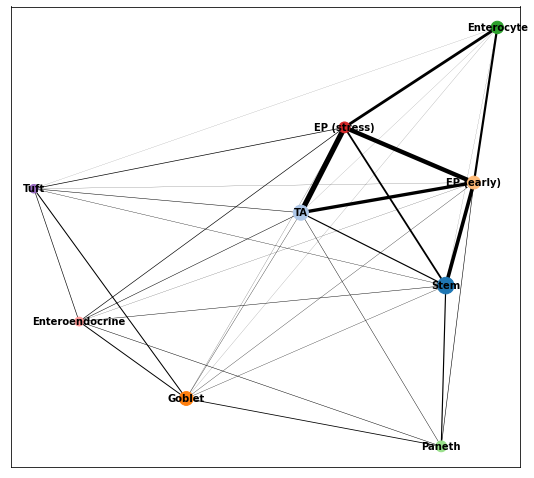

In [103]:
#Recalculate PAGA
sc.tl.paga(adata_test, groups='louvain_r0.5')
sc.pl.paga_compare(adata_test, basis='umap')
sc.pl.paga(adata_test)

In [104]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata_test = adata.copy()
adata_test.X = adata.raw.X
adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) # recompute number of genes expressed per cell

In [105]:
%%R -i adata_test -o ent_de -o paneth_de

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

#Create data subsets for paneth and Enterocyte subpopulations
sca_ent <- subset(sca, with(colData(sca), louvain_r0.5=='Enterocyte'))
sca_paneth <- subset(sca, with(colData(sca), louvain_r0.5=='Paneth'))


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_ent))
print(dim(sca_paneth))
print("")

sca_ent_filt = sca_ent[rowSums(assay(sca_ent)) != 0, ]
sca_paneth_filt = sca_paneth[rowSums(assay(sca_paneth)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_ent_filt))
print(dim(sca_paneth_filt))


#Define & run hurdle model - Enterocytes
zlmCond_ent <- zlm(formula = ~prox_dist + donor + n_genes, sca=sca_ent_filt)
summaryCond_ent <- summary(zlmCond_ent, doLRT='prox_distProximal')
summaryDt_ent <- summaryCond_ent$datatable

result_ent <- merge(summaryDt_ent[contrast=='prox_distProximal' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_ent[contrast=='prox_distProximal' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_ent[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
ent_de = result_ent[result_ent$FDR<0.01,, drop=F]
ent_de = ent_de[order(ent_de$FDR),]


#Define & run hurdle model - paneth cells
zlmCond_paneth <- zlm(formula = ~prox_dist + donor + n_genes, sca=sca_paneth_filt)
summaryCond_paneth <- summary(zlmCond_paneth, doLRT='prox_distProximal')
summaryDt_paneth <- summaryCond_paneth$datatable

result_paneth <- merge(summaryDt_paneth[contrast=='prox_distProximal' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_paneth[contrast=='prox_distProximal' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_paneth[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
paneth_de = result_paneth[result_paneth$FDR<0.01,, drop=F]
paneth_de = paneth_de[order(paneth_de$FDR),]

/opt/python/lib/python3.8/site-packages/anndata2ri/py2r.py:38: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


[1] "Dimensions before subsetting:"
[1] 12818  1180
[1] 12818   677
[1] ""
[1] "Dimensions after subsetting:"
[1] 12150  1180
[1] 12372   677


In [106]:
#Show top 20 differentially expressed genes for enterocytes (up- and down-regulated)
print(ent_de.shape)
ent_de[:20]

(917, 4)


primerid     Pr(>Chisq)      coef            FDR
1     Fabp6  2.647799e-230 -3.834214  3.217075e-226
2     Fabp1  6.763197e-167  2.314713  4.108642e-163
3      Rbp2  2.503491e-144  2.014290  1.013914e-140
4     Adh6a  4.894727e-112  1.055977  1.486773e-108
5    Tspan1  3.802765e-108 -0.887529  9.240718e-105
6      Krt8  1.872504e-102 -0.712311   3.791821e-99
7    Tm4sf5   4.668072e-96  0.846915   8.102439e-93
8     Casp6   2.211888e-88  0.722107   3.359305e-85
9      Adh1   2.750693e-88  0.533162   3.713435e-85
10   Guca2a   4.104884e-88 -1.242187   4.987434e-85
11     Suox   2.489903e-84 -0.387351   2.750211e-81
12    Gstm3   2.898668e-81  0.806124   2.934902e-78
13   Tmsb4x   1.689605e-80 -0.775190   1.579131e-77
14     Mdh2   2.773125e-79  0.557431   2.406676e-76
15      Cd9   3.390840e-77 -0.825868   2.746580e-74
16    Prap1   8.409926e-75  0.859495   6.386287e-72
17     Arg2   1.812475e-74  0.859345   1.295387e-71
18      Khk   4.863661e-72  0.756612   3.282971e-69
19    Apoa4   8.569991e-69  0.811310   5.480284e-66
20      Cda   4.911801e-68  0.657357   2.983919e-65

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


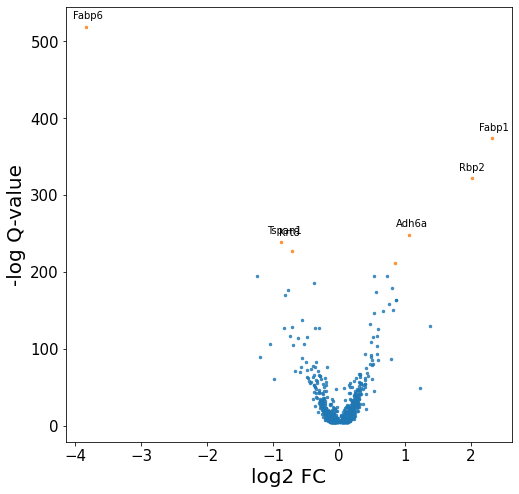

In [107]:
#Volcano plot of results
ent_de['-logQ'] = -np.log(ent_de['FDR'])
lowqval_de = ent_de.loc[ent_de['-logQ'] > 200]
other_de = ent_de.loc[ent_de['-logQ'] < 200]

fig, ax = plt.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log2 FC", fontsize=20)
ax.set_ylabel("-log Q-value", fontsize=20)
ax.tick_params(labelsize=15)

# Label names and positions
x = [i-0.2 for i in lowqval_de['coef']]
y = [i+10 for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 230 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
y = [y[i]+10 if txt == 'Krt8' else y[i] for i,txt in enumerate(labels)]
y = [y[i]+20 if txt == 'Cd9' else y[i] for i,txt in enumerate(labels)]

#Move down one label
y = [y[i]-20 if txt == 'Phgr1' else y[i] for i,txt in enumerate(labels)]

for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

In [108]:

#See overlaps with markers expected for proximal and distal enterocytes
prox_de_set = set(ent_de['primerid'][ent_de['coef'] > 0])
dist_de_set = set(ent_de['primerid'][ent_de['coef'] < 0])
print("Fraction of proximal enterocyte markers in up-regulated proximal DE genes: {}".format(len(prox_de_set.intersection(marker_genes['Enterocyte (Proximal)']))/len(marker_genes['Enterocyte (Proximal)'])))
print("Fraction of distal enterocyte markers in up-regulated proximal DE genes: {}".format(len(prox_de_set.intersection(marker_genes['Enterocyte (Distal)']))/len(marker_genes['Enterocyte (Distal)'])))

print()
print("Fraction of proximal enterocyte markers in up-regulated distal DE genes: {}".format(len(dist_de_set.intersection(marker_genes['Enterocyte (Proximal)']))/len(marker_genes['Enterocyte (Proximal)'])))
print("Fraction of distal enterocyte markers in up-regulated distal DE genes: {}".format(len(dist_de_set.intersection(marker_genes['Enterocyte (Distal)']))/len(marker_genes['Enterocyte (Distal)'])))

Fraction of proximal enterocyte markers in up-regulated proximal DE genes: 0.9166666666666666
Fraction of distal enterocyte markers in up-regulated proximal DE genes: 0.045454545454545456

Fraction of proximal enterocyte markers in up-regulated distal DE genes: 0.0
Fraction of distal enterocyte markers in up-regulated distal DE genes: 0.5227272727272727


In [109]:
#Interpretation of differentially expressed genes in paneth cells - g:profiler
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

paneth_enrichment = gp.profile(organism='mmusculus', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               background=adata.var_names.tolist(), 
                               query=paneth_de['primerid'].tolist())

In [110]:
#paneth_enrich_results = paneth_enrichment.sort_values('p.value').iloc[:,[2,3,5,6,11]]
paneth_enrich_results = paneth_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [111]:
pd.set_option("display.max_colwidth", 800)
paneth_enrich_results.iloc[:50,:]

p_value  term_size  intersection_size    recall  \
native                                                             
GO:0043603  5.251462e-13        874                 68  0.077803   
GO:0006518  1.100250e-12        700                 59  0.084286   
GO:0043604  1.665245e-12        651                 56  0.086022   
GO:0006412  1.665245e-12        551                 51  0.092559   
GO:0043043  3.902226e-12        567                 51  0.089947   
GO:1901566  3.902226e-12       1235                 80  0.064777   
GO:0002181  1.113195e-10         92                 20  0.217391   
GO:0042742  1.055828e-07        132                 20  0.151515   
GO:0044419  9.602412e-07        900                 55  0.061111   
GO:0009617  3.168668e-06        387                 32  0.082687   
GO:0042274  3.908519e-06         65                 13  0.200000   
GO:0000028  4.225557e-06         19                  8  0.421053   
GO:0061844  4.961010e-06         45                 11  0.244444   
GO:0006959  5.391802e-06         94                 15  0.159574   
GO:0051707  5.391802e-06        805                 49  0.060870   
GO:0043207  5.391802e-06        805                 49  0.060870   
GO:0009605  8.399106e-06       1564                 76  0.048593   
GO:0009607  1.518766e-05        835                 49  0.058683   
GO:0019730  5.627159e-05         58                 11  0.189655   
GO:0050830  6.419922e-05         59                 11  0.186441   
GO:0098542  9.633823e-05        558                 36  0.064516   
GO:0050829  1.671960e-04         41                  9  0.219512   
GO:0048002  5.994717e-04         36                  8  0.222222   
GO:0006955  1.094575e-03        864                 45  0.052083   
GO:0006119  1.712228e-03         99                 12  0.121212   
GO:0006457  2.066547e-03        136                 14  0.102941   
GO:1901564  2.404635e-03       4435                152  0.034273   
GO:0042255  2.404635e-03         57                  9  0.157895   
GO:0002821  2.611862e-03         58                  9  0.155172   
GO:0046034  3.373856e-03        203                 17  0.083744   
GO:0022900  3.709782e-03        109                 12  0.110092   
GO:0002428  3.896394e-03         15                  5  0.333333   
GO:0042127  3.946108e-03       1008                 48  0.047619   
GO:0061077  3.946108e-03         48                  8  0.166667   
GO:0001906  4.891737e-03         80                 10  0.125000   
GO:0002711  4.891737e-03         26                  6  0.230769   
GO:0006950  4.891737e-03       2403                 92  0.038285   
GO:1905517  4.891737e-03         26                  6  0.230769   
GO:0002376  4.891737e-03       1474                 63  0.042741   
GO:0002478  4.891737e-03         16                  5  0.312500   
GO:0002475  5.774769e-03         17                  5  0.294118   
GO:0042221  5.774769e-03       2558                 96  0.037529   
GO:0010664  5.774769e-03         27                  6  0.222222   
GO:0042254  6.198839e-03        264                 19  0.071970   
GO:0019882  6.198839e-03         68                  9  0.132353   
GO:0010033  6.252696e-03       2004                 79  0.039421   
GO:1901796  6.708645e-03         54                  8  0.148148   
GO:1901798  6.948802e-03         18                  5  0.277778   
GO:0097529  8.760771e-03        106                 11  0.103774   
GO:0008284  9.359589e-03        550                 30  0.054545   

                                                                                 name  
native                                                                                 
GO:0043603                                           cellular amide metabolic process  
GO:0006518                                                  peptide metabolic process  
GO:0043604                                                 amide biosynthetic process  
GO:0006412                              

In [10]:
from gprofiler_plotting import plot_enrich

plot_enrich(paneth_enrich_results)

NameError: name 'paneth_enrich_results' is not defined

In [113]:
#Write to file
adata.write('/root/host_home/SC_RNA_SEQ/data/Haber-et-al_mouse-intestinal-epithelium/Haber_et_al_case_study.h5ad')

In [ ]:
# If you want to read the already completed file here it is
import anndata
anndata.read_h5ad('/root/host_home/SC_RNA_SEQ/data/Haber-et-al_mouse-intestinal-epithelium/Haber_et_al_case_study.h5ad')